In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split


In [2]:
import os  # Add this line at the beginning of your code

save_dir = '/kaggle/working/'  # Specify your directory path
os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist


In [3]:
# Ensure reproducibility
tf.random.set_seed(42)
np.random.seed(42)


In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Paths to the dataset
image_dir_1 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1'
image_dir_2 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2'
metadata_file = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv'

# Load metadata CSV
labels = pd.read_csv(metadata_file)

# Convert diagnosis (dx) to integers (you can map specific diseases if needed)
label_mapping = {label: idx for idx, label in enumerate(labels['dx'].unique())}
labels['dx'] = labels['dx'].map(label_mapping)

# Set image size for the model
IMG_SIZE = 28  # Resize images to 28x28

# Function to load and preprocess images
def load_images_and_labels(labels, image_dir_1, image_dir_2, img_size=28):
    images = []
    label_list = []

    for _, row in labels.iterrows():
        # Get the file path for the image
        file_path_1 = os.path.join(image_dir_1, row['image_id'] + '.jpg')
        file_path_2 = os.path.join(image_dir_2, row['image_id'] + '.jpg')

        # Check if the image exists in part 1 or part 2
        if os.path.exists(file_path_1):
            img = image.load_img(file_path_1, target_size=(img_size, img_size))
        elif os.path.exists(file_path_2):
            img = image.load_img(file_path_2, target_size=(img_size, img_size))
        else:
            continue  # Skip if image file is missing

        # Convert image to numpy array and normalize it
        img_array = image.img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
        images.append(img_array)
        label_list.append(row['dx'])  # Add the label (dx)

    X = np.array(images)  # Shape: (num_samples, img_size, img_size, 3)
    y = np.array(label_list)  # Labels: [0, 1, 2, ..., 6] for classification
    return X, y

# Load the images and labels
X, y = load_images_and_labels(labels, image_dir_1, image_dir_2, IMG_SIZE)

# Step 1: Split into 80% training and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Split the 80% training set into 80% training and 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# Check the shape of the dataset
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

# Convert labels to one-hot encoding
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=7)  # Assuming 7 classes
y_val_one_hot = tf.keras.utils.to_categorical(y_val, num_classes=7)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=7)

# Compute class weights to handle class imbalance
def compute_class_weights(labels):
    class_weights = compute_class_weight(
        class_weight='balanced', classes=np.unique(labels), y=labels
    )
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
    return class_weight_dict

class_weights = compute_class_weights(y_train)

# Data Augmentation for the training set
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Normalization for the validation set
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Creating data pipeline for training and validation
train_dataset = train_datagen.flow(X_train, y_train_one_hot, batch_size=16)
val_dataset = val_datagen.flow(X_val, y_val_one_hot, batch_size=16)

# Efficient data pipeline: cache, batch, and prefetch (for training and validation datasets)
def create_dataset(X_train, y_train_one_hot, X_val, y_val_one_hot, X_test, y_test_one_hot, batch_size):
    train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train_one_hot))
    val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val_one_hot))
    test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test_one_hot))

    # Efficient data pipeline: cache, batch, and prefetch
    train_data = (train_data
                  .cache()
                  .shuffle(buffer_size=1000)
                  .batch(batch_size)
                  .prefetch(tf.data.experimental.AUTOTUNE))
    
    val_data = (val_data
                .cache()
                .batch(batch_size)
                .prefetch(tf.data.experimental.AUTOTUNE))

    test_data = (test_data
                 .cache()
                 .batch(batch_size)
                 .prefetch(tf.data.experimental.AUTOTUNE))

    return train_data, val_data, test_data

# Set batch size for training
batch_size = 16

# Create the dataset pipeline for efficient data loading
train_data, val_data, test_data = create_dataset(X_train, y_train_one_hot, X_val, y_val_one_hot, X_test, y_test_one_hot, batch_size)


Training set shape: (5608, 28, 28, 3)
Validation set shape: (2404, 28, 28, 3)
Test set shape: (2003, 28, 28, 3)


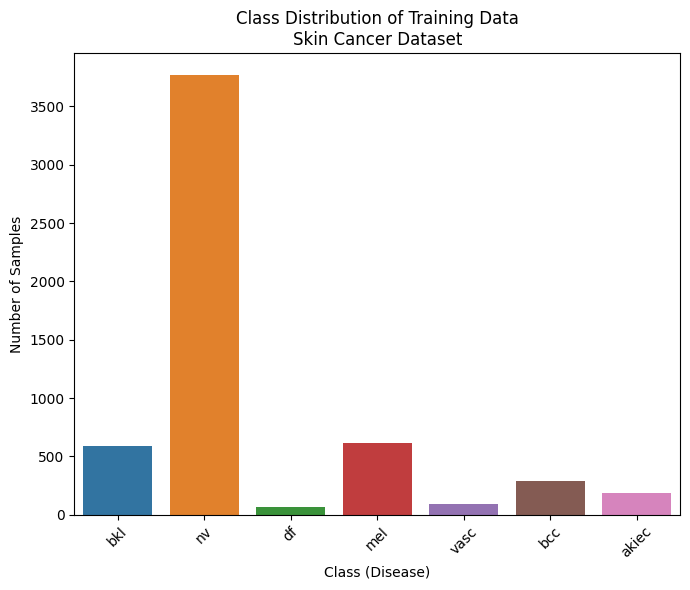

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Add disease names for better interpretation
disease_labels = {v: k for k, v in label_mapping.items()}

# Update the plot function to show disease names on the x-axis
def plot_class_distribution(y_original, title, disease_labels):
    y_original_series = pd.Series(y_original)
    
    original_class_dist = y_original_series.value_counts().sort_index()
    
    # Plot the class distribution
    plt.figure(figsize=(7, 6))
    sns.barplot(x=original_class_dist.index, y=original_class_dist.values)
    plt.title(f'Class Distribution of Training Data\n{title}')
    plt.xlabel('Class (Disease)')
    plt.ylabel('Number of Samples')
    plt.xticks(ticks=original_class_dist.index, labels=[disease_labels.get(i, i) for i in original_class_dist.index], rotation=45)
    plt.tight_layout()
    plt.show()

# Call the updated function to plot the class distribution of the original training data
plot_class_distribution(y_train, 'Skin Cancer Dataset', disease_labels)


Random Image from Training Data:


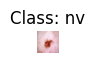

In [6]:
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Function to display a random image from the dataset
def display_random_image(X, y, labels, img_size=28):
    # Pick a random index
    random_index = random.randint(0, len(X) - 1)
    
    # Get the image and its corresponding label
    random_img = X[random_index]
    random_label = y[random_index]
    
    # Convert image array back to displayable format (no resizing)
    random_img_display = image.array_to_img(random_img)
    
    # Get the actual image dimensions
    img_height, img_width, _ = random_img.shape
    
    # Set the figure size based on the actual image size (in inches)
    # Convert pixels to inches (assuming 100 dpi by default)
    figsize = (img_width / 100, img_height / 100)
    
    # Create a new figure with the specified size
    plt.figure(figsize=figsize)
    plt.imshow(random_img_display)
    plt.title(f"Class: {labels[random_label]}")
    plt.axis('off')  # Hide axes for better clarity
    plt.show()

# Display a random image from the original dataset
def visualize_random_image(X_train, y_train, labels_reverse, img_size=28):
    print("Random Image from Training Data:")
    display_random_image(X_train, y_train, labels_reverse, img_size)

# Convert label back to its original class name using the 'label_mapping'
labels_reverse = {v: k for k, v in label_mapping.items()}  # Reverse the label mapping

# Visualize a random image from the original training data at actual size
visualize_random_image(X_train, y_train, labels_reverse, img_size=28)


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

latent_dim = 128  # Latent dimension (size of the compressed representation)

# Encoder (Updated with reduced filters, depthwise separable convolutions, and batch normalization)
encoder = tf.keras.Sequential([
    layers.Input(shape=(28, 28, 3)),
    layers.SeparableConv2D(16, kernel_size=3, strides=2, padding="same", activation="relu", depth_multiplier=1),  # (28, 28) -> (14, 14, 16)
    layers.BatchNormalization(),
    
    layers.SeparableConv2D(32, kernel_size=3, strides=2, padding="same", activation="relu", depth_multiplier=1),  # (14, 14) -> (7, 7, 32)
    layers.BatchNormalization(),
    
    layers.Flatten(),
    layers.Dense(latent_dim)  # Latent representation (128)
])

# Decoder (Updated to output 28x28 with 'same' padding, using depthwise separable convolutions)
decoder = tf.keras.Sequential([
    layers.Input(shape=(latent_dim,)),
    layers.Dense(7 * 7 * 32, activation="relu"),  # Upscale to match the desired dimensions
    layers.Reshape((7, 7, 32)),  # Shape after first dense layer
    layers.BatchNormalization(),
    
    layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="same", activation='relu'),  # (14, 14, 32)
    layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="same", activation='relu'),  # (28, 28, 16)
    layers.Conv2DTranspose(3, kernel_size=3, strides=1, padding="same", activation='sigmoid'),  # (28, 28, 3)
])

# Full autoencoder model
autoencoder_input = layers.Input(shape=(28, 28, 3))  # Changed input shape to (28, 28, 3)
latent_representation = encoder(autoencoder_input)
reconstructed_image = decoder(latent_representation)

autoencoder = models.Model(inputs=autoencoder_input, outputs=reconstructed_image)

# Compile the autoencoder model
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mse')

# Print model summary to check the architecture
autoencoder.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 28, 28, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 128)                 │         201,803 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 28, 28, 3)           │         216,707 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 418,510 (1.60 MB)

 Trainable params: 418,350 (1.60 MB)

 Non-trainable params: 160 (640.00 B)

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_discriminator(input_shape=(28, 28, 3), num_classes=7):
    model = models.Sequential()

    # First convolutional layer with 16 filters and 'same' padding
    model.add(layers.Conv2D(16, kernel_size=(3, 3), input_shape=input_shape, activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    
    # Second convolutional layer with 32 filters and 'valid' padding (matches provided output)
    model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='valid'))  # (28, 28) -> (26, 26)
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))  # (26, 26) -> (13, 13)
    model.add(layers.BatchNormalization())
    
    # Third convolutional layer with 32 filters and 'same' padding
    model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))  # (13, 13) -> (13, 13)

    # Fourth convolutional layer with 64 filters and 'valid' padding
    model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='valid'))  # (13, 13) -> (11, 11)
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))  # (11, 11) -> (6, 6)
    model.add(layers.BatchNormalization())
    
    # Flatten the feature maps
    model.add(layers.Flatten())  # (6, 6, 64) -> 2304

    # Dense layer (fully connected) with 64 units
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))  # Dropout for regularization
    
    # Fully connected (dense) layer with 32 units
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.5))  # Dropout for regularization

    # Output layer with Softmax activation for multi-class classification
    model.add(layers.Dense(num_classes, activation='softmax'))  # Output 7 classes
    
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Create the discriminator model
num_classes = 7  # Number of classes in the dataset (e.g., 7 for HAM10000 dataset)
discriminator = create_discriminator(input_shape=(28, 28, 3), num_classes=num_classes)

# Display the model summary
discriminator.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 26, 26, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 13, 13, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 13, 13, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 5, 5, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 138,055 (539.28 KB)

 Trainable params: 137,831 (538.40 KB)

 Non-trainable params: 224 (896.00 B)

In [9]:

import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from tqdm import tqdm

# Assuming you have an autoencoder model that is already trained
# Use the decoder part of the autoencoder as the generator
generator = autoencoder.layers[-2]  # Decoder of the autoencoder
discriminator = create_discriminator(input_shape=(28, 28, 3), num_classes=7)

# Define the GAN model
def create_gan(generator, discriminator, latent_dim=128):
    # Freeze the discriminator during the generator training
    discriminator.trainable = False

    # Input layer for random noise (latent vector of size 128)
    gan_input = layers.Input(shape=(latent_dim,))
    
    # Use the generator (autoencoder's decoder) to generate images
    x = generator(gan_input)  # Generator generates fake images
    gan_output = discriminator(x)  # Discriminator evaluates the fake image

    # Build the GAN model
    gan = models.Model(gan_input, gan_output)
    
    # Compile the GAN with categorical cross-entropy loss for multi-class classification
    gan.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
    
    return gan

# Loss functions for the autoencoder and discriminator
loss_fn_auto = tf.keras.losses.MeanSquaredError()  # For the autoencoder (reconstruction loss)
loss_fn_disc = tf.keras.losses.CategoricalCrossentropy(from_logits=False)  # For discriminator (classification loss)

# Optimizers for autoencoder and discriminator
opt_autoencoder = tf.keras.optimizers.Adam(learning_rate=0.0001)
opt_disc = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Metrics to store losses and accuracies for tracking
autoencoder_losses_epoch = []
discriminator_losses_epoch = []
discriminator_acc_epoch = []
val_autoencoder_losses_epoch = []
val_discriminator_losses_epoch = []
val_discriminator_acc_epoch = []

# Training loop for GAN
for epoch in range(200):
    # Initialize epoch-wise metrics
    epoch_autoencoder_losses = []
    epoch_discriminator_losses = []
    epoch_discriminator_acc = []
    epoch_val_autoencoder_losses = []
    epoch_val_discriminator_losses = []
    epoch_val_discriminator_acc = []

    # Training loop
    for idx, (batch_real, batch_label) in enumerate(tqdm(train_data)):
        with tf.GradientTape(persistent=True) as tape:
            # Pass batch through the encoder and decoder (autoencoder)
            latent_representation = encoder(batch_real)
            generated_image = decoder(latent_representation)
            loss_autoencoder = loss_fn_auto(batch_real, generated_image)

            # Pass batch through the discriminator (real vs fake image)
            fake = generated_image
            loss_disc_real = loss_fn_disc(batch_label, discriminator(batch_real))
            loss_disc_fake = loss_fn_disc(batch_label, discriminator(fake))
            loss_disc = (loss_disc_real + loss_disc_fake) / 2

        # Apply gradients to autoencoder
        grads_autoencoder = tape.gradient(loss_autoencoder, autoencoder.trainable_weights)
        opt_autoencoder.apply_gradients(zip(grads_autoencoder, autoencoder.trainable_weights))

        # Apply gradients to discriminator
        grads_discriminator = tape.gradient(loss_disc, discriminator.trainable_weights)
        opt_disc.apply_gradients(zip(grads_discriminator, discriminator.trainable_weights))

        # Store batch-wise metrics
        epoch_autoencoder_losses.append(loss_autoencoder.numpy())
        epoch_discriminator_losses.append(loss_disc.numpy())
        epoch_discriminator_acc.append(tf.reduce_mean(
            tf.keras.metrics.categorical_accuracy(batch_label, discriminator(fake))).numpy())

        if idx % 200 == 0:
            img = tf.keras.preprocessing.image.array_to_img(fake[0])
            img.save(f"{save_dir}/generated_img_epoch_{epoch}_batch_{idx}.png")

    # Validation loop
    for val_batch_real, val_batch_label in val_data:
        val_latent_representation = encoder(val_batch_real)
        val_generated_image = decoder(val_latent_representation)
        val_loss_autoencoder = loss_fn_auto(val_batch_real, val_generated_image)
        val_loss_disc_real = loss_fn_disc(val_batch_label, discriminator(val_batch_real))
        val_loss_disc_fake = loss_fn_disc(val_batch_label, discriminator(val_generated_image))
        val_loss_disc = (val_loss_disc_real + val_loss_disc_fake) / 2

        # Calculate accuracy
        val_discriminator_accuracy = tf.reduce_mean(
            tf.keras.metrics.categorical_accuracy(val_batch_label, discriminator(val_generated_image)))

        # Store validation metrics
        epoch_val_autoencoder_losses.append(val_loss_autoencoder.numpy())
        epoch_val_discriminator_losses.append(val_loss_disc.numpy())
        epoch_val_discriminator_acc.append(val_discriminator_accuracy.numpy())

    # Calculate epoch-wise averages and append to the lists
    avg_autoencoder_loss = np.mean(epoch_autoencoder_losses)
    avg_discriminator_loss = np.mean(epoch_discriminator_losses)
    avg_discriminator_acc = np.mean(epoch_discriminator_acc)
    avg_val_autoencoder_loss = np.mean(epoch_val_autoencoder_losses)
    avg_val_discriminator_loss = np.mean(epoch_val_discriminator_losses)
    avg_val_discriminator_acc = np.mean(epoch_val_discriminator_acc)

    autoencoder_losses_epoch.append(avg_autoencoder_loss)
    discriminator_losses_epoch.append(avg_discriminator_loss)
    discriminator_acc_epoch.append(avg_discriminator_acc)
    val_autoencoder_losses_epoch.append(avg_val_autoencoder_loss)
    val_discriminator_losses_epoch.append(avg_val_discriminator_loss)
    val_discriminator_acc_epoch.append(avg_val_discriminator_acc)

    # Print epoch-wise metrics
    print(f"Epoch {epoch}, Autoencoder Loss: {avg_autoencoder_loss}, Discriminator Loss: {avg_discriminator_loss}, Discriminator Accuracy: {avg_discriminator_acc}")
    print(f"Validation - Autoencoder Loss: {avg_val_autoencoder_loss}, Discriminator Loss: {avg_val_discriminator_loss}, Discriminator Accuracy: {avg_val_discriminator_acc}")


100%|██████████| 351/351 [01:41<00:00,  3.47it/s]


Epoch 0, Autoencoder Loss: 0.029327094554901123, Discriminator Loss: 1.2541537284851074, Discriminator Accuracy: 0.6296296119689941
Validation - Autoencoder Loss: 0.019699852913618088, Discriminator Loss: 1.1278797388076782, Discriminator Accuracy: 0.6643211841583252


100%|██████████| 351/351 [01:38<00:00,  3.58it/s]


Epoch 1, Autoencoder Loss: 0.017567813396453857, Discriminator Loss: 1.1024394035339355, Discriminator Accuracy: 0.6716524362564087
Validation - Autoencoder Loss: 0.013447053730487823, Discriminator Loss: 1.057219386100769, Discriminator Accuracy: 0.6643211841583252


100%|██████████| 351/351 [01:37<00:00,  3.60it/s]


Epoch 2, Autoencoder Loss: 0.009888065047562122, Discriminator Loss: 1.0321389436721802, Discriminator Accuracy: 0.6720085740089417
Validation - Autoencoder Loss: 0.00810124259442091, Discriminator Loss: 1.0293126106262207, Discriminator Accuracy: 0.6643211841583252


100%|██████████| 351/351 [01:37<00:00,  3.59it/s]


Epoch 3, Autoencoder Loss: 0.006756625138223171, Discriminator Loss: 1.0087724924087524, Discriminator Accuracy: 0.6723646521568298
Validation - Autoencoder Loss: 0.0059132566675543785, Discriminator Loss: 1.006541132926941, Discriminator Accuracy: 0.6643211841583252


100%|██████████| 351/351 [01:37<00:00,  3.59it/s]


Epoch 4, Autoencoder Loss: 0.005296763032674789, Discriminator Loss: 0.9721804857254028, Discriminator Accuracy: 0.6734330654144287
Validation - Autoencoder Loss: 0.00503545394167304, Discriminator Loss: 0.9691863656044006, Discriminator Accuracy: 0.6643211841583252


100%|██████████| 351/351 [01:37<00:00,  3.59it/s]


Epoch 5, Autoencoder Loss: 0.004705952014774084, Discriminator Loss: 0.9504339098930359, Discriminator Accuracy: 0.6730769276618958
Validation - Autoencoder Loss: 0.004622112959623337, Discriminator Loss: 0.9325565695762634, Discriminator Accuracy: 0.6655629277229309


100%|██████████| 351/351 [01:37<00:00,  3.60it/s]


Epoch 6, Autoencoder Loss: 0.004368569701910019, Discriminator Loss: 0.9303969740867615, Discriminator Accuracy: 0.6750355958938599
Validation - Autoencoder Loss: 0.004326798487454653, Discriminator Loss: 0.9521581530570984, Discriminator Accuracy: 0.6659768223762512


100%|██████████| 351/351 [01:37<00:00,  3.61it/s]


Epoch 7, Autoencoder Loss: 0.004120816942304373, Discriminator Loss: 0.9165645241737366, Discriminator Accuracy: 0.6753917336463928
Validation - Autoencoder Loss: 0.00412417808547616, Discriminator Loss: 0.9192801713943481, Discriminator Accuracy: 0.6701158881187439


100%|██████████| 351/351 [01:37<00:00,  3.61it/s]


Epoch 8, Autoencoder Loss: 0.0038990145549178123, Discriminator Loss: 0.9062396287918091, Discriminator Accuracy: 0.6796652674674988
Validation - Autoencoder Loss: 0.003897684393450618, Discriminator Loss: 0.900649905204773, Discriminator Accuracy: 0.6680463552474976


100%|██████████| 351/351 [01:37<00:00,  3.62it/s]


Epoch 9, Autoencoder Loss: 0.003701151581481099, Discriminator Loss: 0.8901930451393127, Discriminator Accuracy: 0.68660968542099
Validation - Autoencoder Loss: 0.0037054060958325863, Discriminator Loss: 0.8826037049293518, Discriminator Accuracy: 0.675082802772522


100%|██████████| 351/351 [01:36<00:00,  3.62it/s]


Epoch 10, Autoencoder Loss: 0.003535848343744874, Discriminator Loss: 0.8744391798973083, Discriminator Accuracy: 0.690883219242096
Validation - Autoencoder Loss: 0.003583702025935054, Discriminator Loss: 0.8857109546661377, Discriminator Accuracy: 0.6754966974258423


100%|██████████| 351/351 [01:37<00:00,  3.60it/s]


Epoch 11, Autoencoder Loss: 0.0034032051917165518, Discriminator Loss: 0.8661931753158569, Discriminator Accuracy: 0.6921296119689941
Validation - Autoencoder Loss: 0.003452023956924677, Discriminator Loss: 0.9080213308334351, Discriminator Accuracy: 0.6783940196037292


100%|██████████| 351/351 [01:37<00:00,  3.60it/s]


Epoch 12, Autoencoder Loss: 0.0033133369870483875, Discriminator Loss: 0.8509641289710999, Discriminator Accuracy: 0.6992521286010742
Validation - Autoencoder Loss: 0.0033976747654378414, Discriminator Loss: 0.8511374592781067, Discriminator Accuracy: 0.690811276435852


100%|██████████| 351/351 [01:36<00:00,  3.62it/s]


Epoch 13, Autoencoder Loss: 0.003230211092159152, Discriminator Loss: 0.8410270810127258, Discriminator Accuracy: 0.7029914259910583
Validation - Autoencoder Loss: 0.003322182223200798, Discriminator Loss: 0.8777716159820557, Discriminator Accuracy: 0.6821191906929016


100%|██████████| 351/351 [01:36<00:00,  3.63it/s]


Epoch 14, Autoencoder Loss: 0.003159766551107168, Discriminator Loss: 0.8324076533317566, Discriminator Accuracy: 0.6988959908485413
Validation - Autoencoder Loss: 0.0032285924535244703, Discriminator Loss: 0.8359837532043457, Discriminator Accuracy: 0.6899834275245667


100%|██████████| 351/351 [01:36<00:00,  3.63it/s]


Epoch 15, Autoencoder Loss: 0.0030883941799402237, Discriminator Loss: 0.8289912939071655, Discriminator Accuracy: 0.7017450332641602
Validation - Autoencoder Loss: 0.0031761813443154097, Discriminator Loss: 0.8673376441001892, Discriminator Accuracy: 0.6945364475250244


100%|██████████| 351/351 [01:36<00:00,  3.63it/s]


Epoch 16, Autoencoder Loss: 0.003028223756700754, Discriminator Loss: 0.8226454854011536, Discriminator Accuracy: 0.7049501538276672
Validation - Autoencoder Loss: 0.003100787056609988, Discriminator Loss: 0.8257740139961243, Discriminator Accuracy: 0.7011589407920837


100%|██████████| 351/351 [01:36<00:00,  3.64it/s]


Epoch 17, Autoencoder Loss: 0.002966719912365079, Discriminator Loss: 0.8156091570854187, Discriminator Accuracy: 0.7047720551490784
Validation - Autoencoder Loss: 0.003055870532989502, Discriminator Loss: 0.860482931137085, Discriminator Accuracy: 0.6990894079208374


100%|██████████| 351/351 [01:36<00:00,  3.63it/s]


Epoch 18, Autoencoder Loss: 0.0029075988568365574, Discriminator Loss: 0.8080267906188965, Discriminator Accuracy: 0.7079772353172302
Validation - Autoencoder Loss: 0.0029986093286424875, Discriminator Loss: 0.8484926819801331, Discriminator Accuracy: 0.6970198750495911


100%|██████████| 351/351 [01:36<00:00,  3.64it/s]


Epoch 19, Autoencoder Loss: 0.002858852967619896, Discriminator Loss: 0.8023560643196106, Discriminator Accuracy: 0.7101139426231384
Validation - Autoencoder Loss: 0.0029376319143921137, Discriminator Loss: 0.8415284156799316, Discriminator Accuracy: 0.6966059803962708


100%|██████████| 351/351 [01:36<00:00,  3.62it/s]


Epoch 20, Autoencoder Loss: 0.0028132598381489515, Discriminator Loss: 0.7949537038803101, Discriminator Accuracy: 0.7111823558807373
Validation - Autoencoder Loss: 0.002897149184718728, Discriminator Loss: 0.8290684223175049, Discriminator Accuracy: 0.7003311514854431


100%|██████████| 351/351 [01:36<00:00,  3.62it/s]


Epoch 21, Autoencoder Loss: 0.002766139106824994, Discriminator Loss: 0.7946214079856873, Discriminator Accuracy: 0.7101139426231384
Validation - Autoencoder Loss: 0.0028614469338208437, Discriminator Loss: 0.8276861310005188, Discriminator Accuracy: 0.699917197227478


100%|██████████| 351/351 [01:37<00:00,  3.59it/s]


Epoch 22, Autoencoder Loss: 0.0027233504224568605, Discriminator Loss: 0.7898800373077393, Discriminator Accuracy: 0.7108262181282043
Validation - Autoencoder Loss: 0.0028320124838501215, Discriminator Loss: 0.8208639621734619, Discriminator Accuracy: 0.7007450461387634


100%|██████████| 351/351 [01:36<00:00,  3.63it/s]


Epoch 23, Autoencoder Loss: 0.002688220702111721, Discriminator Loss: 0.7831255793571472, Discriminator Accuracy: 0.7124287486076355
Validation - Autoencoder Loss: 0.0027919758576899767, Discriminator Loss: 0.8162980079650879, Discriminator Accuracy: 0.7090231776237488


100%|██████████| 351/351 [01:36<00:00,  3.63it/s]


Epoch 24, Autoencoder Loss: 0.002649230882525444, Discriminator Loss: 0.7810536623001099, Discriminator Accuracy: 0.7140313386917114
Validation - Autoencoder Loss: 0.002759308321401477, Discriminator Loss: 0.8178572058677673, Discriminator Accuracy: 0.7115066051483154


100%|██████████| 351/351 [01:36<00:00,  3.65it/s]


Epoch 25, Autoencoder Loss: 0.002621694467961788, Discriminator Loss: 0.7741456031799316, Discriminator Accuracy: 0.7113603949546814
Validation - Autoencoder Loss: 0.0027387645095586777, Discriminator Loss: 0.8215367794036865, Discriminator Accuracy: 0.7019867300987244


100%|██████████| 351/351 [01:36<00:00,  3.65it/s]


Epoch 26, Autoencoder Loss: 0.002590013202279806, Discriminator Loss: 0.7717238068580627, Discriminator Accuracy: 0.7222222089767456
Validation - Autoencoder Loss: 0.0026873922906816006, Discriminator Loss: 0.8080968856811523, Discriminator Accuracy: 0.7094370722770691


100%|██████████| 351/351 [01:35<00:00,  3.67it/s]


Epoch 27, Autoencoder Loss: 0.002556768013164401, Discriminator Loss: 0.7677692174911499, Discriminator Accuracy: 0.7224003076553345
Validation - Autoencoder Loss: 0.002675123978406191, Discriminator Loss: 0.8173341155052185, Discriminator Accuracy: 0.7044702172279358


100%|██████████| 351/351 [01:37<00:00,  3.60it/s]


Epoch 28, Autoencoder Loss: 0.0025320295244455338, Discriminator Loss: 0.7640447020530701, Discriminator Accuracy: 0.7236467003822327
Validation - Autoencoder Loss: 0.00263098138384521, Discriminator Loss: 0.8437119126319885, Discriminator Accuracy: 0.6970198750495911


100%|██████████| 351/351 [01:37<00:00,  3.60it/s]


Epoch 29, Autoencoder Loss: 0.0025018099695444107, Discriminator Loss: 0.7561165690422058, Discriminator Accuracy: 0.7206196784973145
Validation - Autoencoder Loss: 0.002608605893328786, Discriminator Loss: 0.8066285252571106, Discriminator Accuracy: 0.7090231776237488


100%|██████████| 351/351 [01:37<00:00,  3.62it/s]


Epoch 30, Autoencoder Loss: 0.0024748018477112055, Discriminator Loss: 0.7531351447105408, Discriminator Accuracy: 0.7243589758872986
Validation - Autoencoder Loss: 0.0025967422407120466, Discriminator Loss: 0.8148818016052246, Discriminator Accuracy: 0.7081953883171082


100%|██████████| 351/351 [01:37<00:00,  3.62it/s]


Epoch 31, Autoencoder Loss: 0.0024447846226394176, Discriminator Loss: 0.75143963098526, Discriminator Accuracy: 0.7275640964508057
Validation - Autoencoder Loss: 0.002555396407842636, Discriminator Loss: 0.8065004348754883, Discriminator Accuracy: 0.7139900922775269


100%|██████████| 351/351 [01:35<00:00,  3.69it/s]


Epoch 32, Autoencoder Loss: 0.002405734034255147, Discriminator Loss: 0.7450263500213623, Discriminator Accuracy: 0.7307692170143127
Validation - Autoencoder Loss: 0.002516484120860696, Discriminator Loss: 0.8139868974685669, Discriminator Accuracy: 0.7061258554458618


100%|██████████| 351/351 [01:35<00:00,  3.67it/s]


Epoch 33, Autoencoder Loss: 0.002364441519603133, Discriminator Loss: 0.7363288402557373, Discriminator Accuracy: 0.7291666865348816
Validation - Autoencoder Loss: 0.0024679768830537796, Discriminator Loss: 0.8147248029708862, Discriminator Accuracy: 0.7044702172279358


100%|██████████| 351/351 [01:35<00:00,  3.67it/s]


Epoch 34, Autoencoder Loss: 0.002299588406458497, Discriminator Loss: 0.736283540725708, Discriminator Accuracy: 0.7275640964508057
Validation - Autoencoder Loss: 0.002389569068327546, Discriminator Loss: 0.8310953974723816, Discriminator Accuracy: 0.7065397500991821


100%|██████████| 351/351 [01:35<00:00,  3.66it/s]


Epoch 35, Autoencoder Loss: 0.0022301040589809418, Discriminator Loss: 0.7258625626564026, Discriminator Accuracy: 0.7332621216773987
Validation - Autoencoder Loss: 0.0023387873079627752, Discriminator Loss: 0.8254489302635193, Discriminator Accuracy: 0.7123344540596008


100%|██████████| 351/351 [01:35<00:00,  3.68it/s]


Epoch 36, Autoencoder Loss: 0.0021854948718100786, Discriminator Loss: 0.727287769317627, Discriminator Accuracy: 0.7309473156929016
Validation - Autoencoder Loss: 0.0023312587291002274, Discriminator Loss: 0.804356575012207, Discriminator Accuracy: 0.7144039869308472


100%|██████████| 351/351 [01:35<00:00,  3.68it/s]


Epoch 37, Autoencoder Loss: 0.002159598981961608, Discriminator Loss: 0.7166988849639893, Discriminator Accuracy: 0.7336182594299316
Validation - Autoencoder Loss: 0.002280001062899828, Discriminator Loss: 0.7986111044883728, Discriminator Accuracy: 0.7185430526733398


100%|██████████| 351/351 [01:35<00:00,  3.68it/s]


Epoch 38, Autoencoder Loss: 0.002134693320840597, Discriminator Loss: 0.7071912884712219, Discriminator Accuracy: 0.7380697727203369
Validation - Autoencoder Loss: 0.0022534828167408705, Discriminator Loss: 0.804406464099884, Discriminator Accuracy: 0.7185430526733398


100%|██████████| 351/351 [01:35<00:00,  3.69it/s]


Epoch 39, Autoencoder Loss: 0.0021128777880221605, Discriminator Loss: 0.708077609539032, Discriminator Accuracy: 0.7382478713989258
Validation - Autoencoder Loss: 0.00223397184163332, Discriminator Loss: 0.806199312210083, Discriminator Accuracy: 0.7036423683166504


100%|██████████| 351/351 [01:35<00:00,  3.69it/s]


Epoch 40, Autoencoder Loss: 0.0021004308946430683, Discriminator Loss: 0.6999584436416626, Discriminator Accuracy: 0.744301974773407
Validation - Autoencoder Loss: 0.002236416097730398, Discriminator Loss: 0.8187984228134155, Discriminator Accuracy: 0.7189569473266602


100%|██████████| 351/351 [01:35<00:00,  3.68it/s]


Epoch 41, Autoencoder Loss: 0.0020784204825758934, Discriminator Loss: 0.6958052515983582, Discriminator Accuracy: 0.7428774833679199
Validation - Autoencoder Loss: 0.002203020267188549, Discriminator Loss: 0.8001654148101807, Discriminator Accuracy: 0.6982616186141968


100%|██████████| 351/351 [01:35<00:00,  3.69it/s]


Epoch 42, Autoencoder Loss: 0.002062253886833787, Discriminator Loss: 0.6905309557914734, Discriminator Accuracy: 0.745726466178894
Validation - Autoencoder Loss: 0.0021927247289568186, Discriminator Loss: 0.8132567405700684, Discriminator Accuracy: 0.7052980065345764


100%|██████████| 351/351 [01:35<00:00,  3.68it/s]


Epoch 43, Autoencoder Loss: 0.002048186492174864, Discriminator Loss: 0.6881574988365173, Discriminator Accuracy: 0.7430555820465088
Validation - Autoencoder Loss: 0.0021737772040069103, Discriminator Loss: 0.7875732183456421, Discriminator Accuracy: 0.7173013091087341


100%|██████████| 351/351 [01:34<00:00,  3.70it/s]


Epoch 44, Autoencoder Loss: 0.0020354895386844873, Discriminator Loss: 0.6816844344139099, Discriminator Accuracy: 0.7510683536529541
Validation - Autoencoder Loss: 0.0021576571743935347, Discriminator Loss: 0.7966585755348206, Discriminator Accuracy: 0.7119205594062805


100%|██████████| 351/351 [01:35<00:00,  3.68it/s]


Epoch 45, Autoencoder Loss: 0.0020227935165166855, Discriminator Loss: 0.6689023375511169, Discriminator Accuracy: 0.7555199265480042
Validation - Autoencoder Loss: 0.002145232865586877, Discriminator Loss: 0.8241312503814697, Discriminator Accuracy: 0.7156456708908081


100%|██████████| 351/351 [01:35<00:00,  3.69it/s]


Epoch 46, Autoencoder Loss: 0.002003690227866173, Discriminator Loss: 0.6632315516471863, Discriminator Accuracy: 0.7576566934585571
Validation - Autoencoder Loss: 0.0021395639050751925, Discriminator Loss: 0.8133811950683594, Discriminator Accuracy: 0.6974337697029114


100%|██████████| 351/351 [01:35<00:00,  3.67it/s]


Epoch 47, Autoencoder Loss: 0.0019949532579630613, Discriminator Loss: 0.6628344058990479, Discriminator Accuracy: 0.75445157289505
Validation - Autoencoder Loss: 0.0021265102550387383, Discriminator Loss: 0.8128913640975952, Discriminator Accuracy: 0.7201986908912659


100%|██████████| 351/351 [01:35<00:00,  3.68it/s]


Epoch 48, Autoencoder Loss: 0.0019826453644782305, Discriminator Loss: 0.6563496589660645, Discriminator Accuracy: 0.7567663788795471
Validation - Autoencoder Loss: 0.002115040784701705, Discriminator Loss: 0.807985246181488, Discriminator Accuracy: 0.7094370722770691


100%|██████████| 351/351 [01:34<00:00,  3.70it/s]


Epoch 49, Autoencoder Loss: 0.001968858763575554, Discriminator Loss: 0.6484881639480591, Discriminator Accuracy: 0.7608618140220642
Validation - Autoencoder Loss: 0.00210179528221488, Discriminator Loss: 0.8125743269920349, Discriminator Accuracy: 0.7024006843566895


100%|██████████| 351/351 [01:34<00:00,  3.70it/s]


Epoch 50, Autoencoder Loss: 0.0019573152530938387, Discriminator Loss: 0.6420831680297852, Discriminator Accuracy: 0.7608618140220642
Validation - Autoencoder Loss: 0.002091327914968133, Discriminator Loss: 0.7947492003440857, Discriminator Accuracy: 0.7127483487129211


100%|██████████| 351/351 [01:35<00:00,  3.69it/s]


Epoch 51, Autoencoder Loss: 0.001944873365573585, Discriminator Loss: 0.6373366713523865, Discriminator Accuracy: 0.7667378783226013
Validation - Autoencoder Loss: 0.0020872990135103464, Discriminator Loss: 0.8110746741294861, Discriminator Accuracy: 0.7106788158416748


100%|██████████| 351/351 [01:35<00:00,  3.68it/s]


Epoch 52, Autoencoder Loss: 0.0019336602417752147, Discriminator Loss: 0.6281891465187073, Discriminator Accuracy: 0.7683404684066772
Validation - Autoencoder Loss: 0.002055928111076355, Discriminator Loss: 0.8094441890716553, Discriminator Accuracy: 0.7148178815841675


100%|██████████| 351/351 [01:34<00:00,  3.70it/s]


Epoch 53, Autoencoder Loss: 0.0019234349019825459, Discriminator Loss: 0.6243540048599243, Discriminator Accuracy: 0.7695869207382202
Validation - Autoencoder Loss: 0.0020600887946784496, Discriminator Loss: 0.8415459394454956, Discriminator Accuracy: 0.7131622433662415


100%|██████████| 351/351 [01:35<00:00,  3.68it/s]


Epoch 54, Autoencoder Loss: 0.0019143979297950864, Discriminator Loss: 0.6102300882339478, Discriminator Accuracy: 0.7702991366386414
Validation - Autoencoder Loss: 0.0020466872956603765, Discriminator Loss: 0.807281494140625, Discriminator Accuracy: 0.7164735198020935


100%|██████████| 351/351 [01:34<00:00,  3.70it/s]


Epoch 55, Autoencoder Loss: 0.0019022095948457718, Discriminator Loss: 0.6093018054962158, Discriminator Accuracy: 0.7752848863601685
Validation - Autoencoder Loss: 0.002034404082223773, Discriminator Loss: 0.8011597990989685, Discriminator Accuracy: 0.7210264801979065


100%|██████████| 351/351 [01:35<00:00,  3.69it/s]


Epoch 56, Autoencoder Loss: 0.0018914116080850363, Discriminator Loss: 0.6032196879386902, Discriminator Accuracy: 0.7704772353172302
Validation - Autoencoder Loss: 0.0020197504200041294, Discriminator Loss: 0.8055101037025452, Discriminator Accuracy: 0.7131622433662415


100%|██████████| 351/351 [01:35<00:00,  3.69it/s]


Epoch 57, Autoencoder Loss: 0.0018875154200941324, Discriminator Loss: 0.5920036435127258, Discriminator Accuracy: 0.7806267738342285
Validation - Autoencoder Loss: 0.0020134677179157734, Discriminator Loss: 0.8112316727638245, Discriminator Accuracy: 0.7090231776237488


100%|██████████| 351/351 [01:35<00:00,  3.67it/s]


Epoch 58, Autoencoder Loss: 0.0018726264825090766, Discriminator Loss: 0.5935534834861755, Discriminator Accuracy: 0.7767093777656555
Validation - Autoencoder Loss: 0.0020037577487528324, Discriminator Loss: 0.8110213875770569, Discriminator Accuracy: 0.7222682237625122


100%|██████████| 351/351 [01:36<00:00,  3.65it/s]


Epoch 59, Autoencoder Loss: 0.0018647476099431515, Discriminator Loss: 0.5812463760375977, Discriminator Accuracy: 0.7820512652397156
Validation - Autoencoder Loss: 0.0019930743146687746, Discriminator Loss: 0.7956236004829407, Discriminator Accuracy: 0.7206125855445862


100%|██████████| 351/351 [01:36<00:00,  3.65it/s]


Epoch 60, Autoencoder Loss: 0.0018541754689067602, Discriminator Loss: 0.5753704905509949, Discriminator Accuracy: 0.7827635407447815
Validation - Autoencoder Loss: 0.0019999505020678043, Discriminator Loss: 0.840203583240509, Discriminator Accuracy: 0.7086092829704285


100%|██████████| 351/351 [01:35<00:00,  3.69it/s]


Epoch 61, Autoencoder Loss: 0.0018465304747223854, Discriminator Loss: 0.5707072615623474, Discriminator Accuracy: 0.7868589758872986
Validation - Autoencoder Loss: 0.0019856635481119156, Discriminator Loss: 0.8096094727516174, Discriminator Accuracy: 0.7185430526733398


100%|██████████| 351/351 [01:35<00:00,  3.69it/s]


Epoch 62, Autoencoder Loss: 0.0018366901203989983, Discriminator Loss: 0.565356433391571, Discriminator Accuracy: 0.7907763719558716
Validation - Autoencoder Loss: 0.001964583992958069, Discriminator Loss: 0.8079996109008789, Discriminator Accuracy: 0.7152317762374878


100%|██████████| 351/351 [01:35<00:00,  3.66it/s]


Epoch 63, Autoencoder Loss: 0.0018311473540961742, Discriminator Loss: 0.5572325587272644, Discriminator Accuracy: 0.7927350401878357
Validation - Autoencoder Loss: 0.001973619917407632, Discriminator Loss: 0.8398603796958923, Discriminator Accuracy: 0.7226821184158325


100%|██████████| 351/351 [01:36<00:00,  3.64it/s]


Epoch 64, Autoencoder Loss: 0.0018189505208283663, Discriminator Loss: 0.5534990429878235, Discriminator Accuracy: 0.7941595315933228
Validation - Autoencoder Loss: 0.001958410954102874, Discriminator Loss: 0.7902548909187317, Discriminator Accuracy: 0.7251655459403992


100%|██████████| 351/351 [01:35<00:00,  3.67it/s]


Epoch 65, Autoencoder Loss: 0.0018134786514565349, Discriminator Loss: 0.5426585078239441, Discriminator Accuracy: 0.7986111044883728
Validation - Autoencoder Loss: 0.00194506102707237, Discriminator Loss: 0.8065939545631409, Discriminator Accuracy: 0.7255794405937195


100%|██████████| 351/351 [01:34<00:00,  3.70it/s]


Epoch 66, Autoencoder Loss: 0.0018023831071332097, Discriminator Loss: 0.5410527586936951, Discriminator Accuracy: 0.7984330654144287
Validation - Autoencoder Loss: 0.0019302439177408814, Discriminator Loss: 0.8398182392120361, Discriminator Accuracy: 0.7139900922775269


100%|██████████| 351/351 [01:37<00:00,  3.61it/s]


Epoch 67, Autoencoder Loss: 0.0017957717645913363, Discriminator Loss: 0.5324032306671143, Discriminator Accuracy: 0.8046652674674988
Validation - Autoencoder Loss: 0.001932110171765089, Discriminator Loss: 0.8098869323730469, Discriminator Accuracy: 0.7139900922775269


100%|██████████| 351/351 [01:36<00:00,  3.65it/s]


Epoch 68, Autoencoder Loss: 0.001786880660802126, Discriminator Loss: 0.5253300666809082, Discriminator Accuracy: 0.8021723628044128
Validation - Autoencoder Loss: 0.0019196836510673165, Discriminator Loss: 0.8503764867782593, Discriminator Accuracy: 0.7148178815841675


100%|██████████| 351/351 [01:35<00:00,  3.66it/s]


Epoch 69, Autoencoder Loss: 0.001780206337571144, Discriminator Loss: 0.5134272575378418, Discriminator Accuracy: 0.8046652674674988
Validation - Autoencoder Loss: 0.0019242808921262622, Discriminator Loss: 0.8297747373580933, Discriminator Accuracy: 0.7086092829704285


100%|██████████| 351/351 [01:36<00:00,  3.64it/s]


Epoch 70, Autoencoder Loss: 0.0017743754433467984, Discriminator Loss: 0.5063067078590393, Discriminator Accuracy: 0.81160968542099
Validation - Autoencoder Loss: 0.0019099779892712831, Discriminator Loss: 0.8042311668395996, Discriminator Accuracy: 0.7144039869308472


100%|██████████| 351/351 [01:35<00:00,  3.67it/s]


Epoch 71, Autoencoder Loss: 0.0017641556914895773, Discriminator Loss: 0.504716157913208, Discriminator Accuracy: 0.8096510171890259
Validation - Autoencoder Loss: 0.0019162960816174746, Discriminator Loss: 0.8193177580833435, Discriminator Accuracy: 0.7189569473266602


100%|██████████| 351/351 [01:35<00:00,  3.66it/s]


Epoch 72, Autoencoder Loss: 0.0017577088437974453, Discriminator Loss: 0.4946438670158386, Discriminator Accuracy: 0.81695157289505
Validation - Autoencoder Loss: 0.0018919603899121284, Discriminator Loss: 0.8363823294639587, Discriminator Accuracy: 0.7222682237625122


100%|██████████| 351/351 [01:35<00:00,  3.66it/s]


Epoch 73, Autoencoder Loss: 0.0017505116993561387, Discriminator Loss: 0.4877278804779053, Discriminator Accuracy: 0.81606125831604
Validation - Autoencoder Loss: 0.0018820107216015458, Discriminator Loss: 0.8175258040428162, Discriminator Accuracy: 0.7222682237625122


100%|██████████| 351/351 [01:35<00:00,  3.66it/s]


Epoch 74, Autoencoder Loss: 0.0017451796447858214, Discriminator Loss: 0.4829310178756714, Discriminator Accuracy: 0.8153489828109741
Validation - Autoencoder Loss: 0.0018861787393689156, Discriminator Loss: 0.8279396295547485, Discriminator Accuracy: 0.7156456708908081


100%|██████████| 351/351 [01:35<00:00,  3.66it/s]


Epoch 75, Autoencoder Loss: 0.00173704675398767, Discriminator Loss: 0.47777971625328064, Discriminator Accuracy: 0.819978654384613
Validation - Autoencoder Loss: 0.001871962216682732, Discriminator Loss: 0.8936821222305298, Discriminator Accuracy: 0.684602677822113


100%|██████████| 351/351 [01:35<00:00,  3.69it/s]


Epoch 76, Autoencoder Loss: 0.0017315641744062304, Discriminator Loss: 0.4668284058570862, Discriminator Accuracy: 0.8246082663536072
Validation - Autoencoder Loss: 0.001861856086179614, Discriminator Loss: 0.8008564114570618, Discriminator Accuracy: 0.7177152037620544


100%|██████████| 351/351 [01:35<00:00,  3.68it/s]


Epoch 77, Autoencoder Loss: 0.0017220417503267527, Discriminator Loss: 0.46504372358322144, Discriminator Accuracy: 0.8256766200065613
Validation - Autoencoder Loss: 0.0018656776519492269, Discriminator Loss: 0.8682760000228882, Discriminator Accuracy: 0.7206125855445862


100%|██████████| 351/351 [01:36<00:00,  3.64it/s]


Epoch 78, Autoencoder Loss: 0.0017157226102426648, Discriminator Loss: 0.4541610777378082, Discriminator Accuracy: 0.8313746452331543
Validation - Autoencoder Loss: 0.0018571753753349185, Discriminator Loss: 0.8386939764022827, Discriminator Accuracy: 0.7173013091087341


100%|██████████| 351/351 [01:35<00:00,  3.69it/s]


Epoch 79, Autoencoder Loss: 0.001710170996375382, Discriminator Loss: 0.4445498287677765, Discriminator Accuracy: 0.8338675498962402
Validation - Autoencoder Loss: 0.0018455709796398878, Discriminator Loss: 0.8537803888320923, Discriminator Accuracy: 0.7185430526733398


100%|██████████| 351/351 [01:35<00:00,  3.69it/s]


Epoch 80, Autoencoder Loss: 0.0017048363806679845, Discriminator Loss: 0.4438372552394867, Discriminator Accuracy: 0.8351139426231384
Validation - Autoencoder Loss: 0.0018503920873627067, Discriminator Loss: 0.8478561043739319, Discriminator Accuracy: 0.7189569473266602


100%|██████████| 351/351 [01:34<00:00,  3.71it/s]


Epoch 81, Autoencoder Loss: 0.0017006315756589174, Discriminator Loss: 0.43724921345710754, Discriminator Accuracy: 0.8393874764442444
Validation - Autoencoder Loss: 0.0018312179017812014, Discriminator Loss: 0.8393051028251648, Discriminator Accuracy: 0.7189569473266602


100%|██████████| 351/351 [01:34<00:00,  3.72it/s]


Epoch 82, Autoencoder Loss: 0.0016925049712881446, Discriminator Loss: 0.4298635721206665, Discriminator Accuracy: 0.8372507095336914
Validation - Autoencoder Loss: 0.001825655926950276, Discriminator Loss: 0.851453959941864, Discriminator Accuracy: 0.7156456708908081


100%|██████████| 351/351 [01:34<00:00,  3.72it/s]


Epoch 83, Autoencoder Loss: 0.001685486757196486, Discriminator Loss: 0.41806137561798096, Discriminator Accuracy: 0.8450854420661926
Validation - Autoencoder Loss: 0.0018198908073827624, Discriminator Loss: 0.871882975101471, Discriminator Accuracy: 0.7065397500991821


100%|██████████| 351/351 [01:34<00:00,  3.72it/s]


Epoch 84, Autoencoder Loss: 0.0016797104617580771, Discriminator Loss: 0.4129149913787842, Discriminator Accuracy: 0.8479344844818115
Validation - Autoencoder Loss: 0.0018164262874051929, Discriminator Loss: 0.8957802653312683, Discriminator Accuracy: 0.7272350788116455


100%|██████████| 351/351 [01:34<00:00,  3.70it/s]


Epoch 85, Autoencoder Loss: 0.0016748186899349093, Discriminator Loss: 0.4133090674877167, Discriminator Accuracy: 0.8468660712242126
Validation - Autoencoder Loss: 0.0018150692339986563, Discriminator Loss: 0.8767660856246948, Discriminator Accuracy: 0.7193708419799805


100%|██████████| 351/351 [01:34<00:00,  3.70it/s]


Epoch 86, Autoencoder Loss: 0.0016683796420693398, Discriminator Loss: 0.3969680070877075, Discriminator Accuracy: 0.8561253547668457
Validation - Autoencoder Loss: 0.0018261554650962353, Discriminator Loss: 0.8599544167518616, Discriminator Accuracy: 0.7123344540596008


100%|██████████| 351/351 [01:35<00:00,  3.69it/s]


Epoch 87, Autoencoder Loss: 0.0016636991640552878, Discriminator Loss: 0.39143165946006775, Discriminator Accuracy: 0.8575498461723328
Validation - Autoencoder Loss: 0.0018056925619021058, Discriminator Loss: 0.8991811275482178, Discriminator Accuracy: 0.7288907170295715


100%|██████████| 351/351 [01:34<00:00,  3.71it/s]


Epoch 88, Autoencoder Loss: 0.0016579590737819672, Discriminator Loss: 0.38760775327682495, Discriminator Accuracy: 0.8564814925193787
Validation - Autoencoder Loss: 0.0018043778836727142, Discriminator Loss: 0.8879399299621582, Discriminator Accuracy: 0.7218543291091919


100%|██████████| 351/351 [01:34<00:00,  3.71it/s]


Epoch 89, Autoencoder Loss: 0.0016559066716581583, Discriminator Loss: 0.39045023918151855, Discriminator Accuracy: 0.8564814925193787
Validation - Autoencoder Loss: 0.001787778572179377, Discriminator Loss: 0.8916534185409546, Discriminator Accuracy: 0.7139900922775269


100%|██████████| 351/351 [01:35<00:00,  3.69it/s]


Epoch 90, Autoencoder Loss: 0.0016478055622428656, Discriminator Loss: 0.36518150568008423, Discriminator Accuracy: 0.8700142502784729
Validation - Autoencoder Loss: 0.0017898145597428083, Discriminator Loss: 0.9309225678443909, Discriminator Accuracy: 0.7264072895050049


100%|██████████| 351/351 [01:34<00:00,  3.70it/s]


Epoch 91, Autoencoder Loss: 0.0016421423060819507, Discriminator Loss: 0.36322396993637085, Discriminator Accuracy: 0.8655626773834229
Validation - Autoencoder Loss: 0.0017872242024168372, Discriminator Loss: 0.9086348414421082, Discriminator Accuracy: 0.7284768223762512


100%|██████████| 351/351 [01:34<00:00,  3.72it/s]


Epoch 92, Autoencoder Loss: 0.001636482891626656, Discriminator Loss: 0.3638087809085846, Discriminator Accuracy: 0.8655626773834229
Validation - Autoencoder Loss: 0.0017857089405879378, Discriminator Loss: 0.9202979803085327, Discriminator Accuracy: 0.7090231776237488


100%|██████████| 351/351 [01:34<00:00,  3.71it/s]


Epoch 93, Autoencoder Loss: 0.0016339399153366685, Discriminator Loss: 0.35340893268585205, Discriminator Accuracy: 0.8735755085945129
Validation - Autoencoder Loss: 0.0017808289267122746, Discriminator Loss: 0.934128999710083, Discriminator Accuracy: 0.7193708419799805


100%|██████████| 351/351 [01:35<00:00,  3.69it/s]


Epoch 94, Autoencoder Loss: 0.0016298922710120678, Discriminator Loss: 0.3411637544631958, Discriminator Accuracy: 0.87410968542099
Validation - Autoencoder Loss: 0.0017736913869157434, Discriminator Loss: 0.9236003756523132, Discriminator Accuracy: 0.7094370722770691


100%|██████████| 351/351 [01:35<00:00,  3.69it/s]


Epoch 95, Autoencoder Loss: 0.0016241477569565177, Discriminator Loss: 0.3437654674053192, Discriminator Accuracy: 0.877136766910553
Validation - Autoencoder Loss: 0.0017698577139526606, Discriminator Loss: 0.927446186542511, Discriminator Accuracy: 0.7048841118812561


100%|██████████| 351/351 [01:35<00:00,  3.68it/s]


Epoch 96, Autoencoder Loss: 0.0016191834583878517, Discriminator Loss: 0.3354899287223816, Discriminator Accuracy: 0.87945157289505
Validation - Autoencoder Loss: 0.0017601180588826537, Discriminator Loss: 1.0025449991226196, Discriminator Accuracy: 0.7185430526733398


100%|██████████| 351/351 [01:35<00:00,  3.66it/s]


Epoch 97, Autoencoder Loss: 0.0016170439776033163, Discriminator Loss: 0.3299465477466583, Discriminator Accuracy: 0.879273533821106
Validation - Autoencoder Loss: 0.0017617694102227688, Discriminator Loss: 0.9637370109558105, Discriminator Accuracy: 0.7086092829704285


100%|██████████| 351/351 [01:35<00:00,  3.67it/s]


Epoch 98, Autoencoder Loss: 0.0016103782691061497, Discriminator Loss: 0.32270359992980957, Discriminator Accuracy: 0.883368968963623
Validation - Autoencoder Loss: 0.0017627258785068989, Discriminator Loss: 0.9775172472000122, Discriminator Accuracy: 0.7028145790100098


100%|██████████| 351/351 [01:35<00:00,  3.69it/s]


Epoch 99, Autoencoder Loss: 0.001610511913895607, Discriminator Loss: 0.3115329444408417, Discriminator Accuracy: 0.8872863054275513
Validation - Autoencoder Loss: 0.0017542311688885093, Discriminator Loss: 1.0204975605010986, Discriminator Accuracy: 0.7168874144554138


100%|██████████| 351/351 [01:34<00:00,  3.70it/s]


Epoch 100, Autoencoder Loss: 0.0016019123140722513, Discriminator Loss: 0.3063073754310608, Discriminator Accuracy: 0.8901353478431702
Validation - Autoencoder Loss: 0.0017473743064329028, Discriminator Loss: 0.9921191930770874, Discriminator Accuracy: 0.7011589407920837


100%|██████████| 351/351 [01:35<00:00,  3.69it/s]


Epoch 101, Autoencoder Loss: 0.0015977172879502177, Discriminator Loss: 0.30023109912872314, Discriminator Accuracy: 0.8888888955116272
Validation - Autoencoder Loss: 0.0017497740918770432, Discriminator Loss: 1.0482184886932373, Discriminator Accuracy: 0.7152317762374878


100%|██████████| 351/351 [01:35<00:00,  3.68it/s]


Epoch 102, Autoencoder Loss: 0.0015953861875459552, Discriminator Loss: 0.30261048674583435, Discriminator Accuracy: 0.8931623697280884
Validation - Autoencoder Loss: 0.001743502914905548, Discriminator Loss: 0.9933192729949951, Discriminator Accuracy: 0.7106788158416748


100%|██████████| 351/351 [01:37<00:00,  3.61it/s]


Epoch 103, Autoencoder Loss: 0.0015906523913145065, Discriminator Loss: 0.289472758769989, Discriminator Accuracy: 0.8947649598121643
Validation - Autoencoder Loss: 0.0017298993188887835, Discriminator Loss: 1.0632696151733398, Discriminator Accuracy: 0.7168874144554138


100%|██████████| 351/351 [01:36<00:00,  3.63it/s]


Epoch 104, Autoencoder Loss: 0.0015869184862822294, Discriminator Loss: 0.29117992520332336, Discriminator Accuracy: 0.8954772353172302
Validation - Autoencoder Loss: 0.0017277967417612672, Discriminator Loss: 1.087823748588562, Discriminator Accuracy: 0.7040562629699707


100%|██████████| 351/351 [01:35<00:00,  3.68it/s]


Epoch 105, Autoencoder Loss: 0.0015832396456971765, Discriminator Loss: 0.28014400601387024, Discriminator Accuracy: 0.9001068472862244
Validation - Autoencoder Loss: 0.0017203844618052244, Discriminator Loss: 1.0177050828933716, Discriminator Accuracy: 0.7110927104949951


100%|██████████| 351/351 [01:35<00:00,  3.69it/s]


Epoch 106, Autoencoder Loss: 0.001579717150889337, Discriminator Loss: 0.27132174372673035, Discriminator Accuracy: 0.9102563858032227
Validation - Autoencoder Loss: 0.0017244028858840466, Discriminator Loss: 1.0820256471633911, Discriminator Accuracy: 0.7148178815841675


100%|██████████| 351/351 [01:35<00:00,  3.68it/s]


Epoch 107, Autoencoder Loss: 0.0015733982436358929, Discriminator Loss: 0.26706358790397644, Discriminator Accuracy: 0.9066951274871826
Validation - Autoencoder Loss: 0.0017199107678607106, Discriminator Loss: 1.0960335731506348, Discriminator Accuracy: 0.7102649211883545


100%|██████████| 351/351 [01:34<00:00,  3.70it/s]


Epoch 108, Autoencoder Loss: 0.0015722239622846246, Discriminator Loss: 0.2597498893737793, Discriminator Accuracy: 0.9065170884132385
Validation - Autoencoder Loss: 0.0017227521166205406, Discriminator Loss: 1.107991337776184, Discriminator Accuracy: 0.7148178815841675


100%|██████████| 351/351 [01:35<00:00,  3.67it/s]


Epoch 109, Autoencoder Loss: 0.0015688746934756637, Discriminator Loss: 0.26275789737701416, Discriminator Accuracy: 0.9127492904663086
Validation - Autoencoder Loss: 0.0017199093708768487, Discriminator Loss: 1.1236780881881714, Discriminator Accuracy: 0.7032284736633301


100%|██████████| 351/351 [01:36<00:00,  3.65it/s]


Epoch 110, Autoencoder Loss: 0.001566173043102026, Discriminator Loss: 0.25400036573410034, Discriminator Accuracy: 0.9129273295402527
Validation - Autoencoder Loss: 0.001703582238405943, Discriminator Loss: 1.1595462560653687, Discriminator Accuracy: 0.689155638217926


100%|██████████| 351/351 [01:36<00:00,  3.65it/s]


Epoch 111, Autoencoder Loss: 0.0015613776631653309, Discriminator Loss: 0.25178369879722595, Discriminator Accuracy: 0.9097222089767456
Validation - Autoencoder Loss: 0.001709768665023148, Discriminator Loss: 1.147900104522705, Discriminator Accuracy: 0.7052980065345764


100%|██████████| 351/351 [01:35<00:00,  3.68it/s]


Epoch 112, Autoencoder Loss: 0.0015585069777444005, Discriminator Loss: 0.24162468314170837, Discriminator Accuracy: 0.9159544110298157
Validation - Autoencoder Loss: 0.0016987683484330773, Discriminator Loss: 1.1641281843185425, Discriminator Accuracy: 0.7110927104949951


100%|██████████| 351/351 [01:35<00:00,  3.67it/s]


Epoch 113, Autoencoder Loss: 0.0015534352278336883, Discriminator Loss: 0.2288133203983307, Discriminator Accuracy: 0.9225427508354187
Validation - Autoencoder Loss: 0.0017007658025249839, Discriminator Loss: 1.1671446561813354, Discriminator Accuracy: 0.7119205594062805


100%|██████████| 351/351 [01:38<00:00,  3.56it/s]


Epoch 114, Autoencoder Loss: 0.0015501930611208081, Discriminator Loss: 0.23522570729255676, Discriminator Accuracy: 0.9161324501037598
Validation - Autoencoder Loss: 0.0016936648171395063, Discriminator Loss: 1.181888461112976, Discriminator Accuracy: 0.7057119011878967


100%|██████████| 351/351 [01:36<00:00,  3.63it/s]


Epoch 115, Autoencoder Loss: 0.0015457847621291876, Discriminator Loss: 0.22367793321609497, Discriminator Accuracy: 0.9221866130828857
Validation - Autoencoder Loss: 0.0016951084835454822, Discriminator Loss: 1.211631178855896, Discriminator Accuracy: 0.6870861053466797


100%|██████████| 351/351 [01:35<00:00,  3.68it/s]


Epoch 116, Autoencoder Loss: 0.00154337368439883, Discriminator Loss: 0.21580131351947784, Discriminator Accuracy: 0.9261040091514587
Validation - Autoencoder Loss: 0.001688654418103397, Discriminator Loss: 1.217445731163025, Discriminator Accuracy: 0.7098509669303894


100%|██████████| 351/351 [01:35<00:00,  3.67it/s]


Epoch 117, Autoencoder Loss: 0.0015409603947773576, Discriminator Loss: 0.21649661660194397, Discriminator Accuracy: 0.9211182594299316
Validation - Autoencoder Loss: 0.0016843852354213595, Discriminator Loss: 1.2099661827087402, Discriminator Accuracy: 0.7102649211883545


100%|██████████| 351/351 [01:35<00:00,  3.68it/s]


Epoch 118, Autoencoder Loss: 0.0015367779415100813, Discriminator Loss: 0.20696240663528442, Discriminator Accuracy: 0.9312677979469299
Validation - Autoencoder Loss: 0.0016822644975036383, Discriminator Loss: 1.245964765548706, Discriminator Accuracy: 0.6949503421783447


100%|██████████| 351/351 [01:35<00:00,  3.66it/s]


Epoch 119, Autoencoder Loss: 0.001533898408524692, Discriminator Loss: 0.20188990235328674, Discriminator Accuracy: 0.9312677979469299
Validation - Autoencoder Loss: 0.0016825582133606076, Discriminator Loss: 1.2683957815170288, Discriminator Accuracy: 0.7007450461387634


100%|██████████| 351/351 [01:35<00:00,  3.67it/s]


Epoch 120, Autoencoder Loss: 0.0015294876648113132, Discriminator Loss: 0.2104017287492752, Discriminator Accuracy: 0.9280626773834229
Validation - Autoencoder Loss: 0.0016873663989827037, Discriminator Loss: 1.2853425741195679, Discriminator Accuracy: 0.6978476643562317


100%|██████████| 351/351 [01:36<00:00,  3.63it/s]


Epoch 121, Autoencoder Loss: 0.0015262742526829243, Discriminator Loss: 0.1876552253961563, Discriminator Accuracy: 0.93839031457901
Validation - Autoencoder Loss: 0.0016723445151001215, Discriminator Loss: 1.3308343887329102, Discriminator Accuracy: 0.6854304671287537


100%|██████████| 351/351 [01:36<00:00,  3.65it/s]


Epoch 122, Autoencoder Loss: 0.0015243011293932796, Discriminator Loss: 0.20198868215084076, Discriminator Accuracy: 0.936253547668457
Validation - Autoencoder Loss: 0.001669564051553607, Discriminator Loss: 1.2958577871322632, Discriminator Accuracy: 0.693708598613739


100%|██████████| 351/351 [01:36<00:00,  3.62it/s]


Epoch 123, Autoencoder Loss: 0.0015198326436802745, Discriminator Loss: 0.1883649230003357, Discriminator Accuracy: 0.9360755085945129
Validation - Autoencoder Loss: 0.0016677482053637505, Discriminator Loss: 1.3543472290039062, Discriminator Accuracy: 0.699917197227478


100%|██████████| 351/351 [01:36<00:00,  3.64it/s]


Epoch 124, Autoencoder Loss: 0.0015166926896199584, Discriminator Loss: 0.18266144394874573, Discriminator Accuracy: 0.9403489828109741
Validation - Autoencoder Loss: 0.0016632931074127555, Discriminator Loss: 1.3328111171722412, Discriminator Accuracy: 0.7148178815841675


100%|██████████| 351/351 [01:36<00:00,  3.64it/s]


Epoch 125, Autoencoder Loss: 0.0015147164231166244, Discriminator Loss: 0.17903733253479004, Discriminator Accuracy: 0.9389244914054871
Validation - Autoencoder Loss: 0.001672221696935594, Discriminator Loss: 1.3797813653945923, Discriminator Accuracy: 0.684188723564148


100%|██████████| 351/351 [01:35<00:00,  3.66it/s]


Epoch 126, Autoencoder Loss: 0.0015104732010513544, Discriminator Loss: 0.1861966848373413, Discriminator Accuracy: 0.9382122755050659
Validation - Autoencoder Loss: 0.0016599635127931833, Discriminator Loss: 1.3880149126052856, Discriminator Accuracy: 0.7094370722770691


100%|██████████| 351/351 [01:36<00:00,  3.64it/s]


Epoch 127, Autoencoder Loss: 0.0015079460572451353, Discriminator Loss: 0.17020359635353088, Discriminator Accuracy: 0.94195157289505
Validation - Autoencoder Loss: 0.0016552498564124107, Discriminator Loss: 1.3832266330718994, Discriminator Accuracy: 0.7098509669303894


100%|██████████| 351/351 [01:36<00:00,  3.64it/s]


Epoch 128, Autoencoder Loss: 0.0015048783970996737, Discriminator Loss: 0.16537512838840485, Discriminator Accuracy: 0.9444444179534912
Validation - Autoencoder Loss: 0.0016516370233148336, Discriminator Loss: 1.4466158151626587, Discriminator Accuracy: 0.7115066051483154


100%|██████████| 351/351 [01:36<00:00,  3.63it/s]


Epoch 129, Autoencoder Loss: 0.0015017660334706306, Discriminator Loss: 0.14682339131832123, Discriminator Accuracy: 0.9540598392486572
Validation - Autoencoder Loss: 0.0016472343122586608, Discriminator Loss: 1.446212649345398, Discriminator Accuracy: 0.6970198750495911


100%|██████████| 351/351 [01:36<00:00,  3.63it/s]


Epoch 130, Autoencoder Loss: 0.0014985118759796023, Discriminator Loss: 0.1506851315498352, Discriminator Accuracy: 0.9510327577590942
Validation - Autoencoder Loss: 0.0016470008995383978, Discriminator Loss: 1.4447661638259888, Discriminator Accuracy: 0.692052960395813


100%|██████████| 351/351 [01:37<00:00,  3.61it/s]


Epoch 131, Autoencoder Loss: 0.0014979112893342972, Discriminator Loss: 0.1477346569299698, Discriminator Accuracy: 0.9544159770011902
Validation - Autoencoder Loss: 0.0016466688830405474, Discriminator Loss: 1.508987545967102, Discriminator Accuracy: 0.6986755132675171


100%|██████████| 351/351 [01:36<00:00,  3.64it/s]


Epoch 132, Autoencoder Loss: 0.0014934196369722486, Discriminator Loss: 0.14596374332904816, Discriminator Accuracy: 0.9522792100906372
Validation - Autoencoder Loss: 0.0016405419446527958, Discriminator Loss: 1.490364909172058, Discriminator Accuracy: 0.6982616186141968


100%|██████████| 351/351 [01:36<00:00,  3.62it/s]


Epoch 133, Autoencoder Loss: 0.001491436269134283, Discriminator Loss: 0.15318119525909424, Discriminator Accuracy: 0.9513888955116272
Validation - Autoencoder Loss: 0.001638614572584629, Discriminator Loss: 1.498134732246399, Discriminator Accuracy: 0.7052980065345764


100%|██████████| 351/351 [01:36<00:00,  3.64it/s]


Epoch 134, Autoencoder Loss: 0.0014880647649988532, Discriminator Loss: 0.13139592111110687, Discriminator Accuracy: 0.9572649598121643
Validation - Autoencoder Loss: 0.001637532259337604, Discriminator Loss: 1.5595089197158813, Discriminator Accuracy: 0.7144039869308472


100%|██████████| 351/351 [01:36<00:00,  3.65it/s]


Epoch 135, Autoencoder Loss: 0.001485595479607582, Discriminator Loss: 0.1296491026878357, Discriminator Accuracy: 0.9588675498962402
Validation - Autoencoder Loss: 0.0016357273561879992, Discriminator Loss: 1.6000115871429443, Discriminator Accuracy: 0.6949503421783447


100%|██████████| 351/351 [01:36<00:00,  3.64it/s]


Epoch 136, Autoencoder Loss: 0.0014806112740188837, Discriminator Loss: 0.12863148748874664, Discriminator Accuracy: 0.9613603949546814
Validation - Autoencoder Loss: 0.0016298532718792558, Discriminator Loss: 1.5790164470672607, Discriminator Accuracy: 0.7052980065345764


100%|██████████| 351/351 [01:35<00:00,  3.67it/s]


Epoch 137, Autoencoder Loss: 0.0014790247660130262, Discriminator Loss: 0.12168174237012863, Discriminator Accuracy: 0.9633190631866455
Validation - Autoencoder Loss: 0.0016292269574478269, Discriminator Loss: 1.5707229375839233, Discriminator Accuracy: 0.7044702172279358


100%|██████████| 351/351 [01:35<00:00,  3.68it/s]


Epoch 138, Autoencoder Loss: 0.001476597273722291, Discriminator Loss: 0.1304904967546463, Discriminator Accuracy: 0.9622507095336914
Validation - Autoencoder Loss: 0.00162403448484838, Discriminator Loss: 1.6184501647949219, Discriminator Accuracy: 0.7032284736633301


100%|██████████| 351/351 [01:35<00:00,  3.69it/s]


Epoch 139, Autoencoder Loss: 0.0014750687405467033, Discriminator Loss: 0.1250697821378708, Discriminator Accuracy: 0.9633190631866455
Validation - Autoencoder Loss: 0.0016316142864525318, Discriminator Loss: 1.650577187538147, Discriminator Accuracy: 0.6941224932670593


100%|██████████| 351/351 [01:36<00:00,  3.65it/s]


Epoch 140, Autoencoder Loss: 0.0014725138898938894, Discriminator Loss: 0.12022634595632553, Discriminator Accuracy: 0.9618945717811584
Validation - Autoencoder Loss: 0.0016205054707825184, Discriminator Loss: 1.6254909038543701, Discriminator Accuracy: 0.7007450461387634


100%|██████████| 351/351 [01:35<00:00,  3.66it/s]


Epoch 141, Autoencoder Loss: 0.001469224225729704, Discriminator Loss: 0.1014522984623909, Discriminator Accuracy: 0.9675925970077515
Validation - Autoencoder Loss: 0.0016220215475186706, Discriminator Loss: 1.6701604127883911, Discriminator Accuracy: 0.7115066051483154


100%|██████████| 351/351 [01:36<00:00,  3.65it/s]


Epoch 142, Autoencoder Loss: 0.0014662963803857565, Discriminator Loss: 0.10501354187726974, Discriminator Accuracy: 0.9700854420661926
Validation - Autoencoder Loss: 0.0016134112374857068, Discriminator Loss: 1.6783764362335205, Discriminator Accuracy: 0.6833609342575073


100%|██████████| 351/351 [01:36<00:00,  3.65it/s]


Epoch 143, Autoencoder Loss: 0.001463300664909184, Discriminator Loss: 0.1086331456899643, Discriminator Accuracy: 0.9663461446762085
Validation - Autoencoder Loss: 0.0016138484934344888, Discriminator Loss: 1.7218878269195557, Discriminator Accuracy: 0.695364236831665


100%|██████████| 351/351 [01:35<00:00,  3.66it/s]


Epoch 144, Autoencoder Loss: 0.0014627696946263313, Discriminator Loss: 0.09770605713129044, Discriminator Accuracy: 0.9709757566452026
Validation - Autoencoder Loss: 0.001622623996809125, Discriminator Loss: 1.691171407699585, Discriminator Accuracy: 0.699917197227478


100%|██████████| 351/351 [01:36<00:00,  3.66it/s]


Epoch 145, Autoencoder Loss: 0.0014597021508961916, Discriminator Loss: 0.10215981304645538, Discriminator Accuracy: 0.9691951274871826
Validation - Autoencoder Loss: 0.0016164646949619055, Discriminator Loss: 1.7282435894012451, Discriminator Accuracy: 0.7044702172279358


100%|██████████| 351/351 [01:36<00:00,  3.63it/s]


Epoch 146, Autoencoder Loss: 0.0014547242317348719, Discriminator Loss: 0.09431973844766617, Discriminator Accuracy: 0.9727563858032227
Validation - Autoencoder Loss: 0.001608686288818717, Discriminator Loss: 1.790130376815796, Discriminator Accuracy: 0.7007450461387634


100%|██████████| 351/351 [01:35<00:00,  3.68it/s]


Epoch 147, Autoencoder Loss: 0.0014545056037604809, Discriminator Loss: 0.09541592746973038, Discriminator Accuracy: 0.9720441699028015
Validation - Autoencoder Loss: 0.001603666110895574, Discriminator Loss: 1.9980418682098389, Discriminator Accuracy: 0.701572835445404


100%|██████████| 351/351 [01:35<00:00,  3.69it/s]


Epoch 148, Autoencoder Loss: 0.0014513737987726927, Discriminator Loss: 0.1037786677479744, Discriminator Accuracy: 0.9716880321502686
Validation - Autoencoder Loss: 0.0016047589015215635, Discriminator Loss: 1.7853262424468994, Discriminator Accuracy: 0.7011589407920837


100%|██████████| 351/351 [01:35<00:00,  3.69it/s]


Epoch 149, Autoencoder Loss: 0.0014533079229295254, Discriminator Loss: 0.09794642776250839, Discriminator Accuracy: 0.9732906222343445
Validation - Autoencoder Loss: 0.0016069398261606693, Discriminator Loss: 1.9594875574111938, Discriminator Accuracy: 0.6875


100%|██████████| 351/351 [01:35<00:00,  3.69it/s]


Epoch 150, Autoencoder Loss: 0.0014467490836977959, Discriminator Loss: 0.08003129810094833, Discriminator Accuracy: 0.9782763719558716
Validation - Autoencoder Loss: 0.001598032540641725, Discriminator Loss: 1.903732180595398, Discriminator Accuracy: 0.7073675394058228


100%|██████████| 351/351 [01:34<00:00,  3.70it/s]


Epoch 151, Autoencoder Loss: 0.0014448148431256413, Discriminator Loss: 0.08721713721752167, Discriminator Accuracy: 0.9763176441192627
Validation - Autoencoder Loss: 0.0015979516319930553, Discriminator Loss: 2.0057263374328613, Discriminator Accuracy: 0.7036423683166504


100%|██████████| 351/351 [01:35<00:00,  3.69it/s]


Epoch 152, Autoencoder Loss: 0.0014426684938371181, Discriminator Loss: 0.0790744200348854, Discriminator Accuracy: 0.9793447256088257
Validation - Autoencoder Loss: 0.001597957219928503, Discriminator Loss: 1.918331265449524, Discriminator Accuracy: 0.7069536447525024


100%|██████████| 351/351 [01:34<00:00,  3.72it/s]


Epoch 153, Autoencoder Loss: 0.0014419523067772388, Discriminator Loss: 0.07692386955022812, Discriminator Accuracy: 0.9782763719558716
Validation - Autoencoder Loss: 0.0015922068851068616, Discriminator Loss: 2.0573480129241943, Discriminator Accuracy: 0.6928808093070984


100%|██████████| 351/351 [01:34<00:00,  3.73it/s]


Epoch 154, Autoencoder Loss: 0.0014381760265678167, Discriminator Loss: 0.08549655228853226, Discriminator Accuracy: 0.9773860573768616
Validation - Autoencoder Loss: 0.0015978449955582619, Discriminator Loss: 2.003943920135498, Discriminator Accuracy: 0.6932947039604187


100%|██████████| 351/351 [01:34<00:00,  3.70it/s]


Epoch 155, Autoencoder Loss: 0.0014368672855198383, Discriminator Loss: 0.06608481705188751, Discriminator Accuracy: 0.9850427508354187
Validation - Autoencoder Loss: 0.0015890451613813639, Discriminator Loss: 2.0017783641815186, Discriminator Accuracy: 0.7019867300987244


100%|██████████| 351/351 [01:34<00:00,  3.70it/s]


Epoch 156, Autoencoder Loss: 0.001433794153854251, Discriminator Loss: 0.10656652599573135, Discriminator Accuracy: 0.9711538553237915
Validation - Autoencoder Loss: 0.001585926627740264, Discriminator Loss: 2.02224063873291, Discriminator Accuracy: 0.7007450461387634


100%|██████████| 351/351 [01:34<00:00,  3.71it/s]


Epoch 157, Autoencoder Loss: 0.0014321908820420504, Discriminator Loss: 0.06481684744358063, Discriminator Accuracy: 0.9846866130828857
Validation - Autoencoder Loss: 0.001594581757672131, Discriminator Loss: 1.9501354694366455, Discriminator Accuracy: 0.6928808093070984


100%|██████████| 351/351 [01:35<00:00,  3.69it/s]


Epoch 158, Autoencoder Loss: 0.0014288296224549413, Discriminator Loss: 0.06349411606788635, Discriminator Accuracy: 0.9841524362564087
Validation - Autoencoder Loss: 0.001581675955094397, Discriminator Loss: 2.174321174621582, Discriminator Accuracy: 0.7073675394058228


100%|██████████| 351/351 [01:35<00:00,  3.69it/s]


Epoch 159, Autoencoder Loss: 0.001427872572094202, Discriminator Loss: 0.07381943613290787, Discriminator Accuracy: 0.9811253547668457
Validation - Autoencoder Loss: 0.0015754593769088387, Discriminator Loss: 2.0776500701904297, Discriminator Accuracy: 0.701572835445404


100%|██████████| 351/351 [01:34<00:00,  3.71it/s]


Epoch 160, Autoencoder Loss: 0.0014242545003071427, Discriminator Loss: 0.07272834330797195, Discriminator Accuracy: 0.9818376302719116
Validation - Autoencoder Loss: 0.0015783434500917792, Discriminator Loss: 2.071380376815796, Discriminator Accuracy: 0.6974337697029114


100%|██████████| 351/351 [01:34<00:00,  3.70it/s]


Epoch 161, Autoencoder Loss: 0.0014241806929931045, Discriminator Loss: 0.06780806183815002, Discriminator Accuracy: 0.9852207899093628
Validation - Autoencoder Loss: 0.0015745742712169886, Discriminator Loss: 2.122343063354492, Discriminator Accuracy: 0.6862582564353943


100%|██████████| 351/351 [01:35<00:00,  3.69it/s]


Epoch 162, Autoencoder Loss: 0.0014212389942258596, Discriminator Loss: 0.07450933009386063, Discriminator Accuracy: 0.9809473156929016
Validation - Autoencoder Loss: 0.00157851108815521, Discriminator Loss: 2.155661106109619, Discriminator Accuracy: 0.7040562629699707


100%|██████████| 351/351 [01:35<00:00,  3.68it/s]


Epoch 163, Autoencoder Loss: 0.0014218415599316359, Discriminator Loss: 0.06695253401994705, Discriminator Accuracy: 0.9837962985038757
Validation - Autoencoder Loss: 0.001585284131579101, Discriminator Loss: 2.2232518196105957, Discriminator Accuracy: 0.6862582564353943


100%|██████████| 351/351 [01:35<00:00,  3.69it/s]


Epoch 164, Autoencoder Loss: 0.0014176283730193973, Discriminator Loss: 0.053074926137924194, Discriminator Accuracy: 0.9886040091514587
Validation - Autoencoder Loss: 0.0015704706311225891, Discriminator Loss: 2.2305445671081543, Discriminator Accuracy: 0.6990894079208374


100%|██████████| 351/351 [01:35<00:00,  3.66it/s]


Epoch 165, Autoencoder Loss: 0.0014158812118694186, Discriminator Loss: 0.05066802725195885, Discriminator Accuracy: 0.9880697727203369
Validation - Autoencoder Loss: 0.001566549763083458, Discriminator Loss: 2.1728999614715576, Discriminator Accuracy: 0.699917197227478


100%|██████████| 351/351 [01:34<00:00,  3.71it/s]


Epoch 166, Autoencoder Loss: 0.001416776212863624, Discriminator Loss: 0.04977782070636749, Discriminator Accuracy: 0.9880697727203369
Validation - Autoencoder Loss: 0.0015910889487713575, Discriminator Loss: 2.2494194507598877, Discriminator Accuracy: 0.693708598613739


100%|██████████| 351/351 [01:34<00:00,  3.70it/s]


Epoch 167, Autoencoder Loss: 0.0014125913148745894, Discriminator Loss: 0.07959382236003876, Discriminator Accuracy: 0.9827279448509216
Validation - Autoencoder Loss: 0.0015688678249716759, Discriminator Loss: 2.2825798988342285, Discriminator Accuracy: 0.7019867300987244


100%|██████████| 351/351 [01:35<00:00,  3.68it/s]


Epoch 168, Autoencoder Loss: 0.001409994438290596, Discriminator Loss: 0.06364638358354568, Discriminator Accuracy: 0.9855769276618958
Validation - Autoencoder Loss: 0.0015694171888753772, Discriminator Loss: 2.2379515171051025, Discriminator Accuracy: 0.7019867300987244


100%|██████████| 351/351 [01:34<00:00,  3.72it/s]


Epoch 169, Autoencoder Loss: 0.0014095258666202426, Discriminator Loss: 0.046575769782066345, Discriminator Accuracy: 0.9894943237304688
Validation - Autoencoder Loss: 0.00157447112724185, Discriminator Loss: 2.2908425331115723, Discriminator Accuracy: 0.6974337697029114


100%|██████████| 351/351 [01:33<00:00,  3.74it/s]


Epoch 170, Autoencoder Loss: 0.0014082692796364427, Discriminator Loss: 0.05313559249043465, Discriminator Accuracy: 0.9893162250518799
Validation - Autoencoder Loss: 0.0015627028187736869, Discriminator Loss: 2.274489164352417, Discriminator Accuracy: 0.695364236831665


100%|██████████| 351/351 [01:34<00:00,  3.71it/s]


Epoch 171, Autoencoder Loss: 0.0014042272232472897, Discriminator Loss: 0.041264843195676804, Discriminator Accuracy: 0.9907407164573669
Validation - Autoencoder Loss: 0.001558867865242064, Discriminator Loss: 2.335578203201294, Discriminator Accuracy: 0.6924669146537781


100%|██████████| 351/351 [01:34<00:00,  3.70it/s]


Epoch 172, Autoencoder Loss: 0.001402690657414496, Discriminator Loss: 0.08284880965948105, Discriminator Accuracy: 0.9832621216773987
Validation - Autoencoder Loss: 0.0015567441005259752, Discriminator Loss: 2.212726593017578, Discriminator Accuracy: 0.6924669146537781


100%|██████████| 351/351 [01:34<00:00,  3.72it/s]


Epoch 173, Autoencoder Loss: 0.0014004522236064076, Discriminator Loss: 0.04086907580494881, Discriminator Accuracy: 0.9914529919624329
Validation - Autoencoder Loss: 0.0015602662460878491, Discriminator Loss: 2.295576572418213, Discriminator Accuracy: 0.6966059803962708


100%|██████████| 351/351 [01:34<00:00,  3.73it/s]


Epoch 174, Autoencoder Loss: 0.0013988522114232183, Discriminator Loss: 0.0378916896879673, Discriminator Accuracy: 0.9935897588729858
Validation - Autoencoder Loss: 0.0015551092801615596, Discriminator Loss: 2.271501064300537, Discriminator Accuracy: 0.6932947039604187


100%|██████████| 351/351 [01:36<00:00,  3.65it/s]


Epoch 175, Autoencoder Loss: 0.0013960485812276602, Discriminator Loss: 0.04085605964064598, Discriminator Accuracy: 0.9926994442939758
Validation - Autoencoder Loss: 0.0015513115795329213, Discriminator Loss: 2.4189703464508057, Discriminator Accuracy: 0.7135761380195618


100%|██████████| 351/351 [01:36<00:00,  3.64it/s]


Epoch 176, Autoencoder Loss: 0.0013949171407148242, Discriminator Loss: 0.033892612904310226, Discriminator Accuracy: 0.9937677979469299
Validation - Autoencoder Loss: 0.0015476658008992672, Discriminator Loss: 2.428330659866333, Discriminator Accuracy: 0.681291401386261


100%|██████████| 351/351 [01:33<00:00,  3.75it/s]


Epoch 177, Autoencoder Loss: 0.0013946994440630078, Discriminator Loss: 0.04141172394156456, Discriminator Accuracy: 0.9939458966255188
Validation - Autoencoder Loss: 0.0015486376360058784, Discriminator Loss: 2.4700746536254883, Discriminator Accuracy: 0.7028145790100098


100%|██████████| 351/351 [01:33<00:00,  3.75it/s]


Epoch 178, Autoencoder Loss: 0.0013922096695750952, Discriminator Loss: 0.057236429303884506, Discriminator Accuracy: 0.9894943237304688
Validation - Autoencoder Loss: 0.0015441306168213487, Discriminator Loss: 2.765958786010742, Discriminator Accuracy: 0.699917197227478


100%|██████████| 351/351 [01:35<00:00,  3.69it/s]


Epoch 179, Autoencoder Loss: 0.0013895309530198574, Discriminator Loss: 0.04155387729406357, Discriminator Accuracy: 0.9912749528884888
Validation - Autoencoder Loss: 0.0015450684586539865, Discriminator Loss: 2.496527671813965, Discriminator Accuracy: 0.7019867300987244


100%|██████████| 351/351 [01:33<00:00,  3.75it/s]


Epoch 180, Autoencoder Loss: 0.001388435484841466, Discriminator Loss: 0.06995678693056107, Discriminator Accuracy: 0.9866452813148499
Validation - Autoencoder Loss: 0.0015564466593787074, Discriminator Loss: 2.442100763320923, Discriminator Accuracy: 0.693708598613739


100%|██████████| 351/351 [01:34<00:00,  3.71it/s]


Epoch 181, Autoencoder Loss: 0.0013859602622687817, Discriminator Loss: 0.04562871903181076, Discriminator Accuracy: 0.9907407164573669
Validation - Autoencoder Loss: 0.0015404154546558857, Discriminator Loss: 2.4665191173553467, Discriminator Accuracy: 0.695364236831665


100%|██████████| 351/351 [01:34<00:00,  3.70it/s]


Epoch 182, Autoencoder Loss: 0.0013841037871316075, Discriminator Loss: 0.027028905227780342, Discriminator Accuracy: 0.995726466178894
Validation - Autoencoder Loss: 0.0015411553904414177, Discriminator Loss: 2.504727602005005, Discriminator Accuracy: 0.6982616186141968


100%|██████████| 351/351 [01:35<00:00,  3.67it/s]


Epoch 183, Autoencoder Loss: 0.0013822277542203665, Discriminator Loss: 0.020586470142006874, Discriminator Accuracy: 0.9971510171890259
Validation - Autoencoder Loss: 0.001546362997032702, Discriminator Loss: 2.593277931213379, Discriminator Accuracy: 0.7057119011878967


100%|██████████| 351/351 [01:35<00:00,  3.69it/s]


Epoch 184, Autoencoder Loss: 0.0013804601039737463, Discriminator Loss: 0.057919058948755264, Discriminator Accuracy: 0.9884259104728699
Validation - Autoencoder Loss: 0.001539000659249723, Discriminator Loss: 2.610621690750122, Discriminator Accuracy: 0.7135761380195618


100%|██████████| 351/351 [01:34<00:00,  3.73it/s]


Epoch 185, Autoencoder Loss: 0.0013791065430268645, Discriminator Loss: 0.05438520386815071, Discriminator Accuracy: 0.9887820482254028
Validation - Autoencoder Loss: 0.0015411846106871963, Discriminator Loss: 2.451917886734009, Discriminator Accuracy: 0.7081953883171082


100%|██████████| 351/351 [01:34<00:00,  3.71it/s]


Epoch 186, Autoencoder Loss: 0.001377843669615686, Discriminator Loss: 0.022522369399666786, Discriminator Accuracy: 0.9962607026100159
Validation - Autoencoder Loss: 0.001541104051284492, Discriminator Loss: 2.579231023788452, Discriminator Accuracy: 0.7127483487129211


100%|██████████| 351/351 [01:33<00:00,  3.74it/s]


Epoch 187, Autoencoder Loss: 0.0013780761510133743, Discriminator Loss: 0.018494512885808945, Discriminator Accuracy: 0.9983974099159241
Validation - Autoencoder Loss: 0.0015350368339568377, Discriminator Loss: 2.6114351749420166, Discriminator Accuracy: 0.6879138946533203


100%|██████████| 351/351 [01:34<00:00,  3.73it/s]


Epoch 188, Autoencoder Loss: 0.0013776851119473577, Discriminator Loss: 0.1388721466064453, Discriminator Accuracy: 0.9727563858032227
Validation - Autoencoder Loss: 0.0015402949647977948, Discriminator Loss: 2.451650619506836, Discriminator Accuracy: 0.695364236831665


100%|██████████| 351/351 [01:34<00:00,  3.71it/s]


Epoch 189, Autoencoder Loss: 0.0013727002078667283, Discriminator Loss: 0.02621440403163433, Discriminator Accuracy: 0.9950142502784729
Validation - Autoencoder Loss: 0.0015367141459137201, Discriminator Loss: 2.486337184906006, Discriminator Accuracy: 0.6932947039604187


100%|██████████| 351/351 [01:34<00:00,  3.72it/s]


Epoch 190, Autoencoder Loss: 0.001370741636492312, Discriminator Loss: 0.0169638954102993, Discriminator Accuracy: 0.9976851940155029
Validation - Autoencoder Loss: 0.0015283027896657586, Discriminator Loss: 2.565556764602661, Discriminator Accuracy: 0.7073675394058228


100%|██████████| 351/351 [01:34<00:00,  3.70it/s]


Epoch 191, Autoencoder Loss: 0.0013690842315554619, Discriminator Loss: 0.016185682266950607, Discriminator Accuracy: 0.9976851940155029
Validation - Autoencoder Loss: 0.0015248620184138417, Discriminator Loss: 2.7569620609283447, Discriminator Accuracy: 0.7119205594062805


100%|██████████| 351/351 [01:35<00:00,  3.67it/s]


Epoch 192, Autoencoder Loss: 0.001370851183310151, Discriminator Loss: 0.025010116398334503, Discriminator Accuracy: 0.995726466178894
Validation - Autoencoder Loss: 0.0015298797516152263, Discriminator Loss: 2.6789753437042236, Discriminator Accuracy: 0.6924669146537781


100%|██████████| 351/351 [01:34<00:00,  3.73it/s]


Epoch 193, Autoencoder Loss: 0.001364650670439005, Discriminator Loss: 0.05698346346616745, Discriminator Accuracy: 0.9894943237304688
Validation - Autoencoder Loss: 0.0015251085860654712, Discriminator Loss: 2.653210401535034, Discriminator Accuracy: 0.690397322177887


100%|██████████| 351/351 [01:33<00:00,  3.74it/s]


Epoch 194, Autoencoder Loss: 0.0013638626551255584, Discriminator Loss: 0.018234454095363617, Discriminator Accuracy: 0.99732905626297
Validation - Autoencoder Loss: 0.0015360534889623523, Discriminator Loss: 2.7775685787200928, Discriminator Accuracy: 0.6966059803962708


100%|██████████| 351/351 [01:35<00:00,  3.67it/s]


Epoch 195, Autoencoder Loss: 0.001363388728350401, Discriminator Loss: 0.0331549309194088, Discriminator Accuracy: 0.995726466178894
Validation - Autoencoder Loss: 0.0015231042634695768, Discriminator Loss: 2.8224680423736572, Discriminator Accuracy: 0.6862582564353943


100%|██████████| 351/351 [01:34<00:00,  3.73it/s]


Epoch 196, Autoencoder Loss: 0.0013612245675176382, Discriminator Loss: 0.05667462572455406, Discriminator Accuracy: 0.9891381859779358
Validation - Autoencoder Loss: 0.0015225341776385903, Discriminator Loss: 2.7529585361480713, Discriminator Accuracy: 0.7135761380195618


100%|██████████| 351/351 [01:34<00:00,  3.72it/s]


Epoch 197, Autoencoder Loss: 0.0013598244404420257, Discriminator Loss: 0.0152058657258749, Discriminator Accuracy: 0.9983974099159241
Validation - Autoencoder Loss: 0.0015230891294777393, Discriminator Loss: 2.6806304454803467, Discriminator Accuracy: 0.7011589407920837


100%|██████████| 351/351 [01:34<00:00,  3.71it/s]


Epoch 198, Autoencoder Loss: 0.0013576592318713665, Discriminator Loss: 0.015547079965472221, Discriminator Accuracy: 0.99821937084198
Validation - Autoencoder Loss: 0.0015178007306531072, Discriminator Loss: 2.744744062423706, Discriminator Accuracy: 0.6895695328712463


100%|██████████| 351/351 [01:33<00:00,  3.75it/s]


Epoch 199, Autoencoder Loss: 0.0013555703917518258, Discriminator Loss: 0.022346803918480873, Discriminator Accuracy: 0.9967948794364929
Validation - Autoencoder Loss: 0.0015262343222275376, Discriminator Loss: 2.7387444972991943, Discriminator Accuracy: 0.6974337697029114


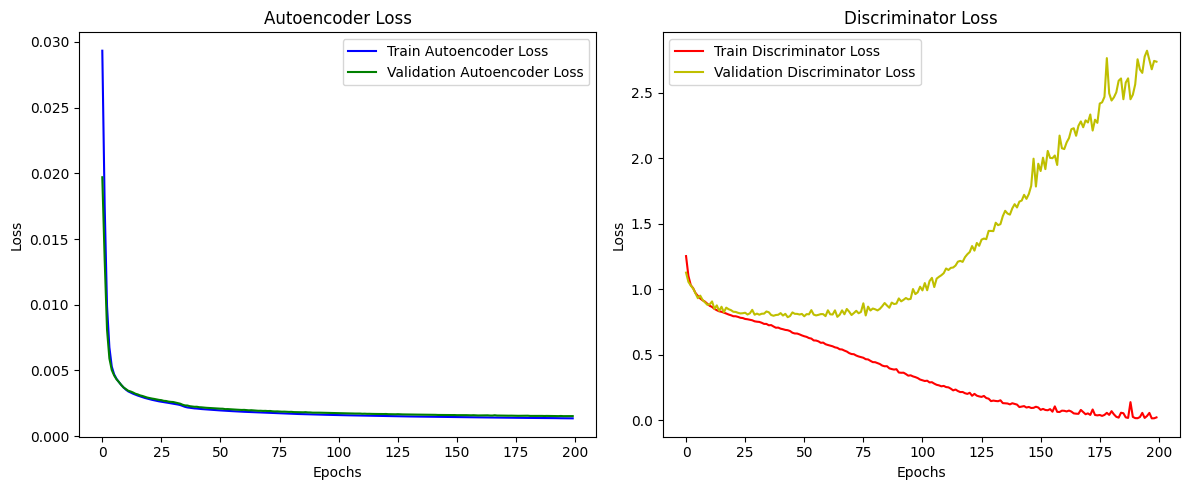

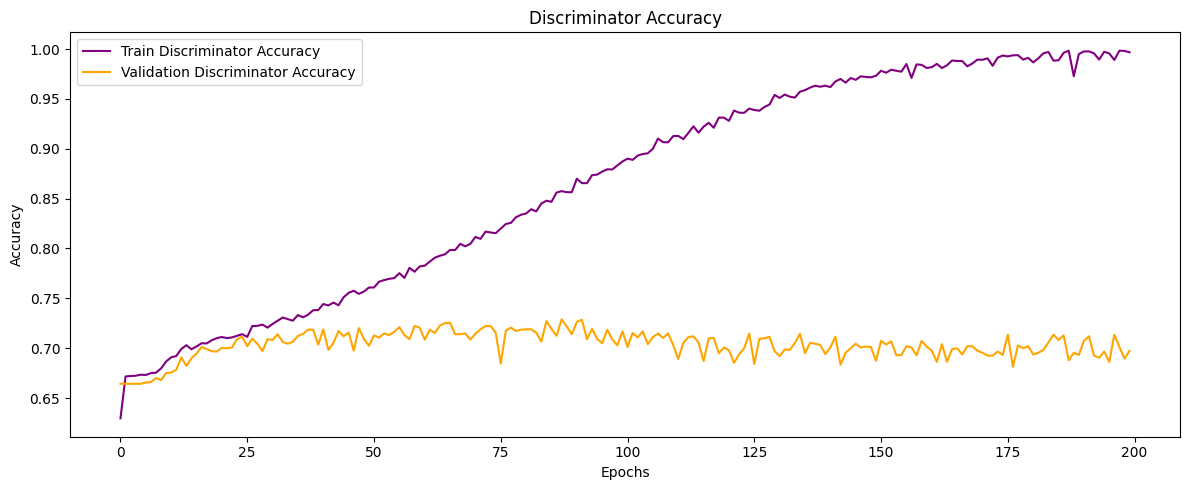

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot the loss curves
def plot_loss_curves():
    plt.figure(figsize=(12, 5))

    # Autoencoder loss
    plt.subplot(1, 2, 1)
    plt.plot(autoencoder_losses_epoch, label="Train Autoencoder Loss", color="b")
    plt.plot(val_autoencoder_losses_epoch, label="Validation Autoencoder Loss", color="g")
    plt.title("Autoencoder Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Discriminator loss
    plt.subplot(1, 2, 2)
    plt.plot(discriminator_losses_epoch, label="Train Discriminator Loss", color="r")
    plt.plot(val_discriminator_losses_epoch, label="Validation Discriminator Loss", color="y")
    plt.title("Discriminator Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Function to plot discriminator accuracy
def plot_discriminator_accuracy():
    plt.figure(figsize=(12, 5))

    # Discriminator accuracy
    plt.plot(discriminator_acc_epoch, label="Train Discriminator Accuracy", color="purple")
    plt.plot(val_discriminator_acc_epoch, label="Validation Discriminator Accuracy", color="orange")
    plt.title("Discriminator Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Function to display generated images at regular intervals
def visualize_generated_images(epoch, generated_images, save_dir="generated_images"):
    # Save generated image at the end of the epoch
    if epoch % 10 == 0:  # Adjust frequency as needed
        plt.figure(figsize=(10, 10))
        for i in range(9):  # Display 9 images in a grid
            plt.subplot(3, 3, i+1)
            plt.imshow(generated_images[i])  # Assuming images are in 3x28x28 format
            plt.axis('off')
        plt.suptitle(f"Generated Images at Epoch {epoch}")
        plt.savefig(f"{save_dir}/generated_images_epoch_{epoch}.png")
        plt.show()

# Visualize loss and accuracy
plot_loss_curves()
plot_discriminator_accuracy()

In [11]:
def evaluate_discriminator(discriminator, test_data):
    test_loss_disease = 0
    test_accuracy_disease = 0
    num_batches = len(test_data)

    for batch_real, batch_label in test_data:
        # Get the output from the discriminator (only disease classification)
        disease_output = discriminator(batch_real)  # Discriminator now outputs (batch_size, num_classes)
        
        # Ensure that the output has the correct shape for comparison
        if len(disease_output.shape) == 2:
            # Check if the output is of shape (batch_size, num_classes)
            print(f"Correct shape for disease_output: {disease_output.shape}")
        else:
            # If it's not, we should reshape it
            disease_output = tf.reshape(disease_output, (batch_real.shape[0], -1))
            print(f"Reshaped disease_output to: {disease_output.shape}")

        # Compute loss for disease classification
        loss_disc_disease = loss_fn_disc(batch_label, disease_output)  # Disease classification loss
        test_loss_disease += loss_disc_disease.numpy()

        # Calculate accuracy for disease classification
        accuracy_disease = tf.reduce_mean(tf.keras.metrics.categorical_accuracy(batch_label, disease_output))
        test_accuracy_disease += accuracy_disease.numpy()

    # Average losses and accuracy
    test_loss_disease /= num_batches
    test_accuracy_disease /= num_batches

    print(f"Test Loss (Disease): {test_loss_disease:.4f}")
    print(f"Test Accuracy (Disease): {test_accuracy_disease:.4f}")

# Evaluate the discriminator on the test data
evaluate_discriminator(discriminator, test_data)


Correct shape for disease_output: (16, 7)
Correct shape for disease_output: (16, 7)
Correct shape for disease_output: (16, 7)
Correct shape for disease_output: (16, 7)
Correct shape for disease_output: (16, 7)
Correct shape for disease_output: (16, 7)
Correct shape for disease_output: (16, 7)
Correct shape for disease_output: (16, 7)
Correct shape for disease_output: (16, 7)
Correct shape for disease_output: (16, 7)
Correct shape for disease_output: (16, 7)
Correct shape for disease_output: (16, 7)
Correct shape for disease_output: (16, 7)
Correct shape for disease_output: (16, 7)
Correct shape for disease_output: (16, 7)
Correct shape for disease_output: (16, 7)
Correct shape for disease_output: (16, 7)
Correct shape for disease_output: (16, 7)
Correct shape for disease_output: (16, 7)
Correct shape for disease_output: (16, 7)
Correct shape for disease_output: (16, 7)
Correct shape for disease_output: (16, 7)
Correct shape for disease_output: (16, 7)
Correct shape for disease_output: 